# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [1]:
import math
import os
import collections
import copy
import typing as ty

import numpy as np
from matplotlib import pyplot as plt
import tqdm.auto as tqdm

import jax
import jax.numpy as jnp

plt.style.use('ggplot')

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [2]:
def draw(nodes, color='g', ax=None):
    if ax is None:
        _fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax.plot(nodes[:, 0], nodes[:, 1], 'ko')
    ax.plot(nodes[:, 0], nodes[:, 1], 'c-')
    for i, theta in enumerate(nodes[:, 2]):
        x2 = 0.25 * math.cos(nodes[i, 2]) + nodes[i, 0]
        y2 = 0.25 * math.sin(nodes[i, 2]) + nodes[i, 1]
        ax.plot([nodes[i, 0], x2], [nodes[i, 1], y2], f'{color}->')
    return ax

In [30]:
class Trajectory:
    
    class Node:
        
        def __init__(self, x, y, theta, *, matrix=None, index=-1):
            self.index = index
            self.matrix = matrix
            if self.matrix is None:
                self.matrix = jnp.array([x, y, theta])

        @property
        def x(self):
            return self.matrix[0]
        
        @property
        def y(self):
            return self.matrix[1]

        @property
        def theta(self):
            return self.matrix[2]
            
        @classmethod
        def read(cls, readout):
            _label, index, x, y, theta = readout.split()
            return cls(float(x), float(y), float(theta), index=int(index))
        
        def __repr__(self):
            return f"VERTEX_SE2 {self.index} {self.x} {self.y} {self.theta}"
                
        def transform(self, x, y, theta):
            affine_transform = jnp.array([x, y, theta])
            rotation_transform = jnp.array([
                [jnp.cos(self.theta), -jnp.sin(self.theta), 0],
                [jnp.sin(self.theta),  jnp.cos(self.theta), 0],
                [                  0,                    0, 1],
            ])
            self.matrix += rotation_transform @ affine_transform
            
        
    class Edge:
        
        def __init__(self, u, v, delta: ty.Tuple[float, float, float], *, printable_metadata: str = ""):
            self.u, self.v = u, v
            self.d_x, self.d_y, self.d_theta = delta
            self.printable_metadata = printable_metadata
        
        @classmethod
        def read(cls, readout):
            _label, u, v, dx, dy, dtheta, i1, i2, i3, i4, i5, i6 = readout.split()
            return cls(int(u), int(v), (float(dx), float(dy), float(dtheta)), 
                       printable_metadata=" ".join([i1, i2, i3, i4, i5, i6]))

        def __repr__(self):
            return f"EDGE_SE2 {self.u} {self.v} {self.d_x} {self.d_y} {self.d_theta}"
        
        @property
        def matrix(self):
            return jnp.array([self.u, self.v, self.d_x, self.d_y, self.d_theta])
        

    def __init__(self, color='g'):
        self.nodes = []
        self.edges = []
        self.color = color
        self.anchors = ([], [])
        
    def set_anchor(self, index):
        self.anchors[0].append(index)
        self.anchors[1].append(copy.deepcopy(self.nodes[index]))
        
    def read(self, filename):
        with open(filename, 'r') as f:
            for line in f.readlines():
                line = line.strip()
                if "VERTEX_SE2" in line:
                    self.nodes.append(self.Node.read(line))
                if "EDGE_SE2" in line:
                    self.edges.append(self.Edge.read(line))
                if "FIX" in line:
                    _label, node = line.split()
                    self.set_anchor(int(node))
                    
    def write(self, filename):
        with open(filename, 'w') as f:
            f.write(repr(graph))
    
    def generate_nodes_from_edges(self):
        # Make enough space in the array for all nodes
        number_of_nodes = len(self.nodes)
        for edge in self.edges:
            number_of_nodes = max(number_of_nodes, edge.u + 1, edge.v + 1)
        self.nodes = self.nodes + [None for _ in range(len(self.nodes), number_of_nodes)]
        # Compute the properties of those nodes
        for edge in self.edges:
            if edge.v - edge.u == 1 and self.nodes[edge.u] is not None and self.nodes[edge.v] is None:
                self.nodes[edge.v] = copy.deepcopy(self.nodes[edge.u])
                self.nodes[edge.v].transform(edge.d_x, edge.d_y, edge.d_theta)
                self.nodes[edge.v].index = edge.v

    def draw(self):
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        x = np.array(list(map(lambda node: node.x, self.nodes)))
        y = np.array(list(map(lambda node: node.y, self.nodes)))
        theta = np.array(list(map(lambda node: node.theta, self.nodes)))
        ax.plot(x, y, 'ko')
        ax.plot(x, y, 'c-')

        for i in range(len(theta)):
            x2 = 0.25 * math.cos(theta[i]) + x[i]
            y2 = 0.25 * math.sin(theta[i]) + y[i]
            ax.plot([x[i], x2], [y[i], y2], f'{self.color}->')
        return ax

    def load_node_matrix(self, matrix):
        for node, vector in zip(self.nodes, matrix):
            node.matrix = vector
    
    def __repr__(self):
        nodes_repr = "\n".join([repr(node) for node in self.nodes if node is not None])
        edges_repr = "\n".join([repr(edge) for edge in self.edges])
        return nodes_repr + "\n" + edges_repr
    
    @property
    def node_matrix(self):
        return jnp.stack([node.matrix for node in self.nodes], axis=0)
    
    @property
    def edge_matrix(self):
        return jnp.stack([edge.matrix for edge in edge.nodes], axis=0)
    
    @property
    def anchor_matrix(self):
        return jnp.stack([node.matrix for node in self.anchors[1]], axis=0)

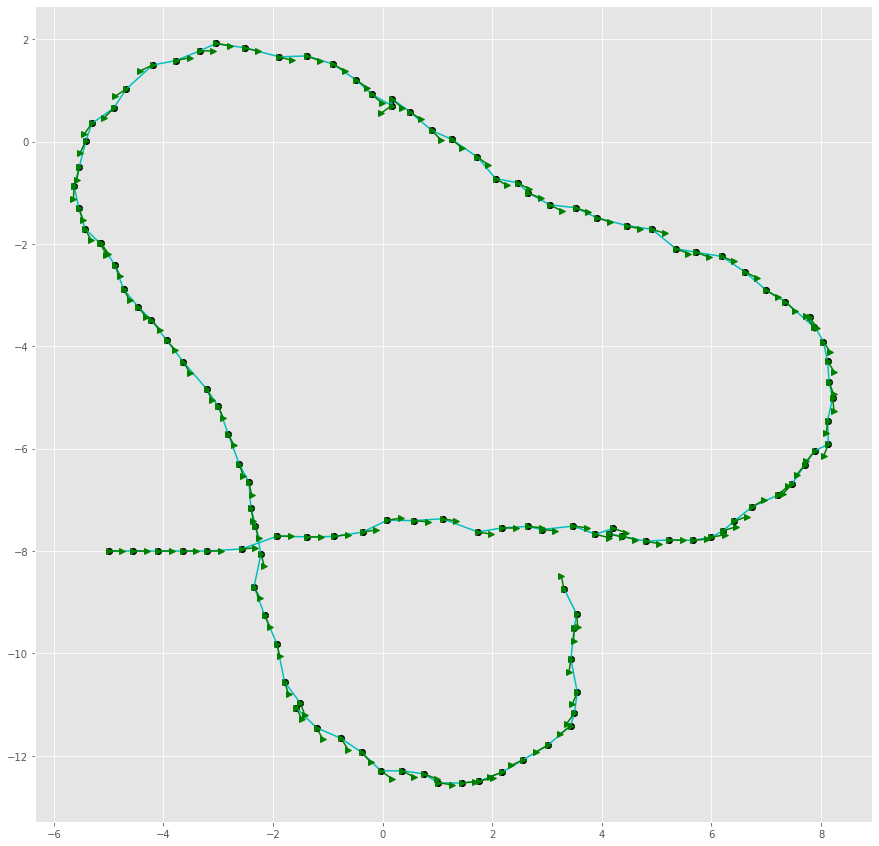

In [31]:
graph = Trajectory()
graph.read("../data/edges.txt")
graph.generate_nodes_from_edges()
ax = graph.draw()
plt.show()

os.makedirs("../results/q2", exist_ok=True)
graph.write("../results/q2/initial_trajectory.g2o")

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

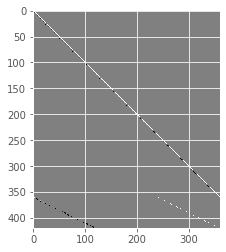

In [5]:
def residual(nodes, graph):
    residue = []
    # Add error of moving the anchors around to the residue
    anchors_present = jnp.stack([nodes[idx] for idx in graph.anchors[0]], axis=0)
    anchor_movement = np.squeeze(anchors_present - graph.anchor_matrix)
    residue.extend(anchor_movement)
    # Add residues for all other edges, direct measures and loop closures
    for edge in graph.edges:
        u_pose = nodes[edge.u]
        v_pose = nodes[edge.v]

        u_pose += jnp.array([
            [jnp.cos(u_pose[2]), -jnp.sin(u_pose[2]), 0],
            [jnp.sin(u_pose[2]),  jnp.cos(u_pose[2]), 0],
            [                 0,                   0, 1],
        ]) @ jnp.array([edge.d_x, edge.d_y, edge.d_theta])
        
        round_trip_error = v_pose - u_pose
        residue.extend(round_trip_error)
        
    return jnp.asarray(residue)

J = jax.jacfwd(residual, argnums=0)(graph.node_matrix, graph).reshape((420, -1))

plt.imshow(J, cmap='gray')
plt.show()

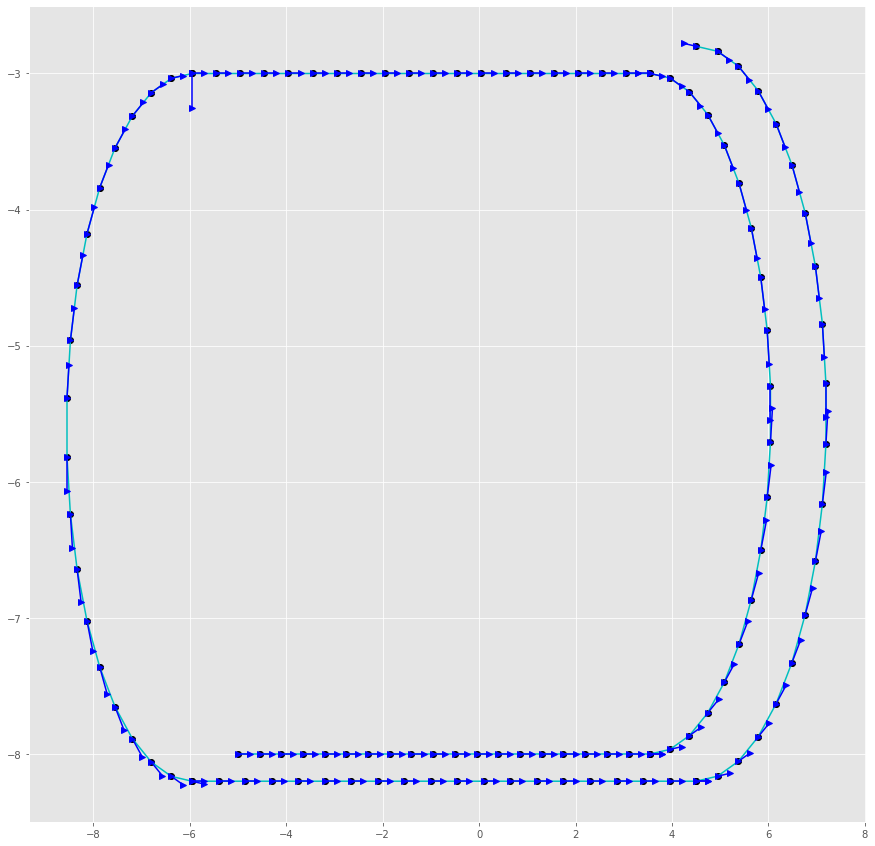

In [6]:
ground_truth = Trajectory(color='b')
ground_truth.read("../data/gt.txt")
ground_truth.generate_nodes_from_edges()
ax = ground_truth.draw()
plt.show()

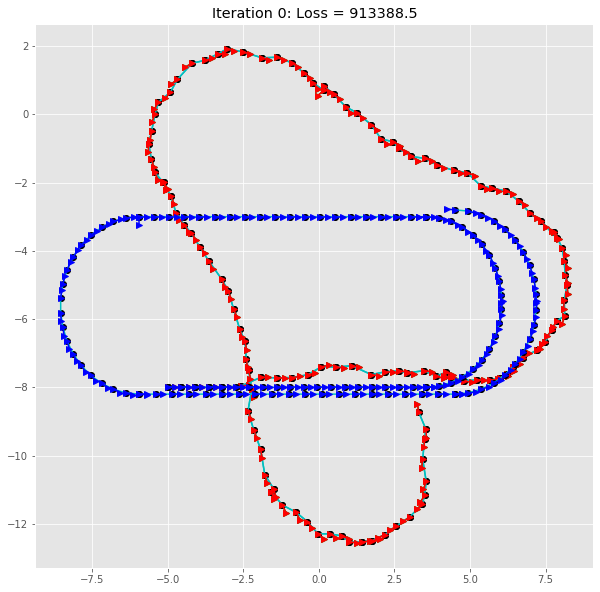

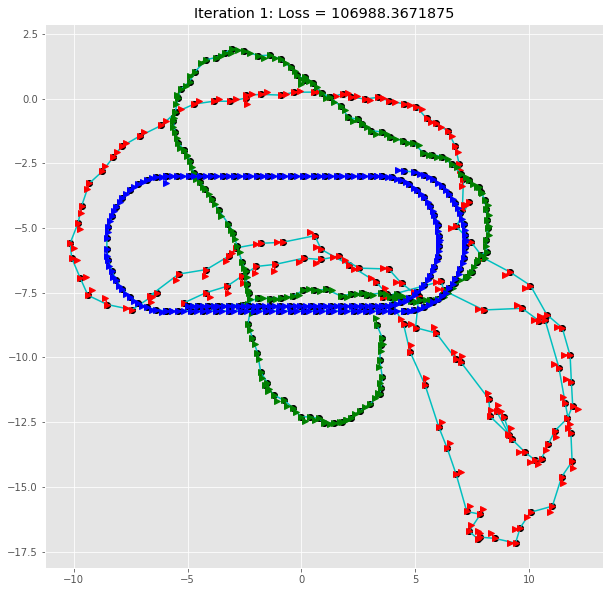

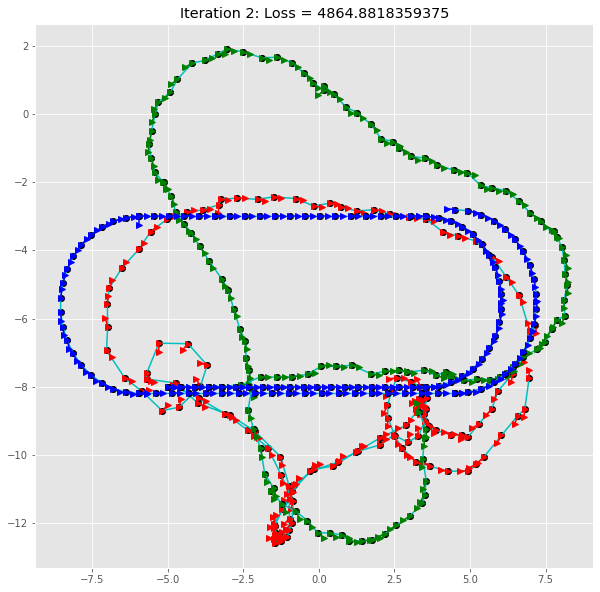

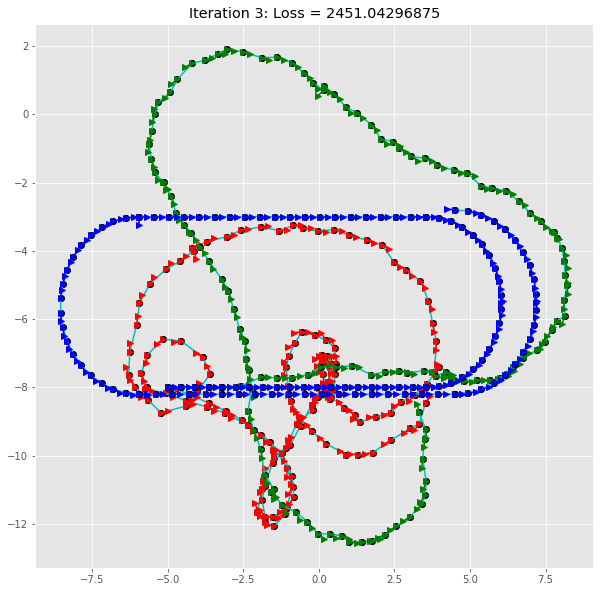

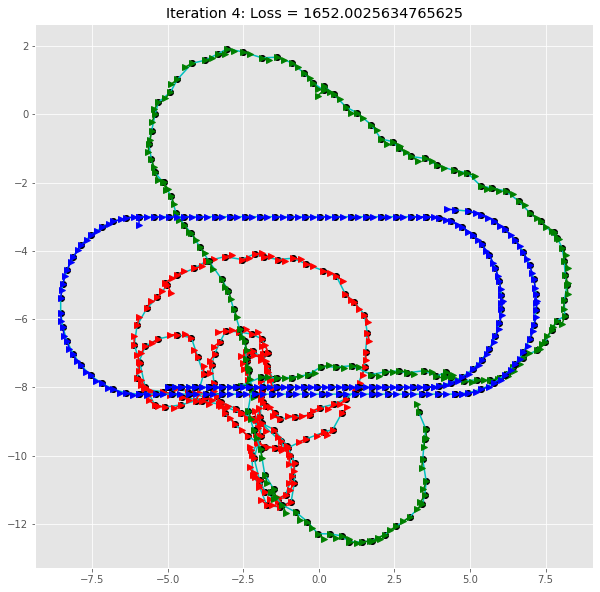

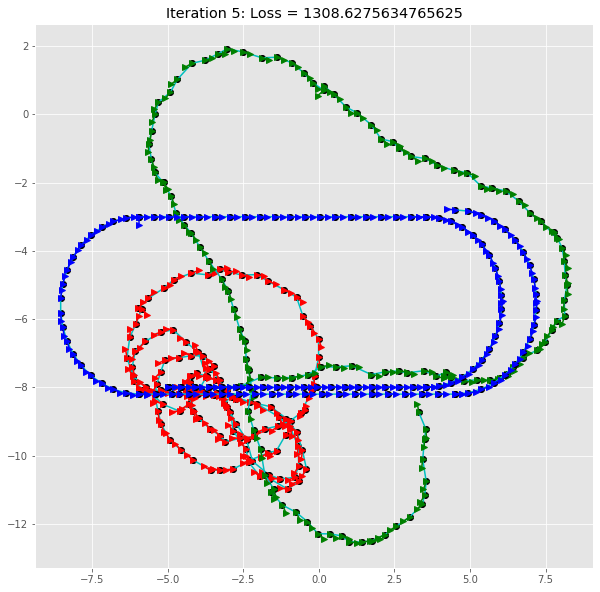

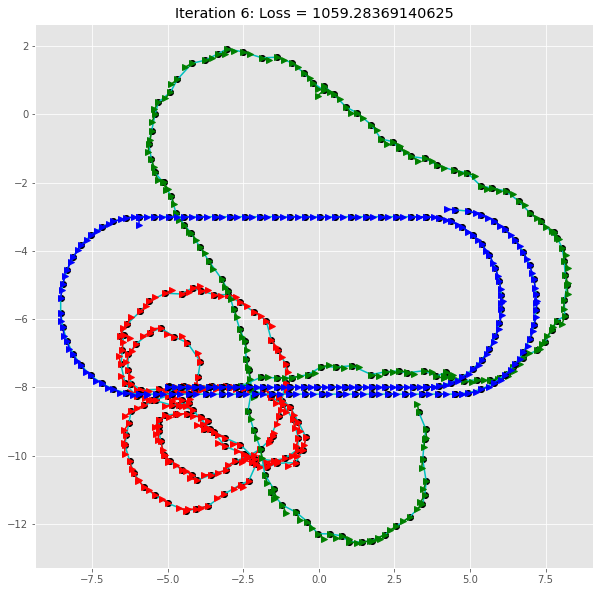

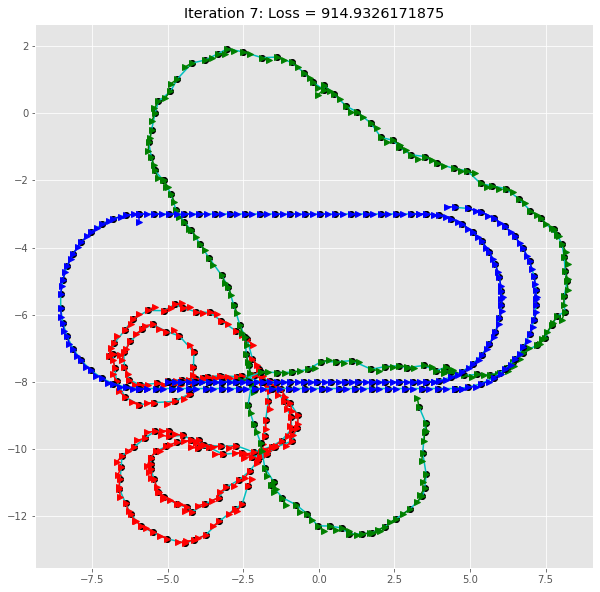

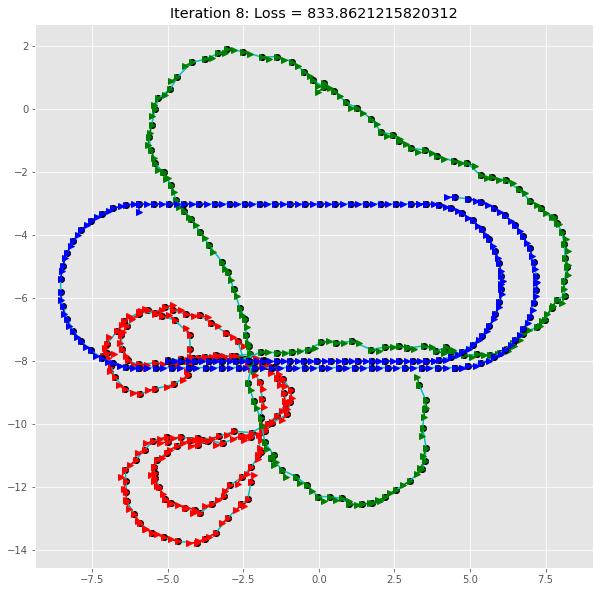

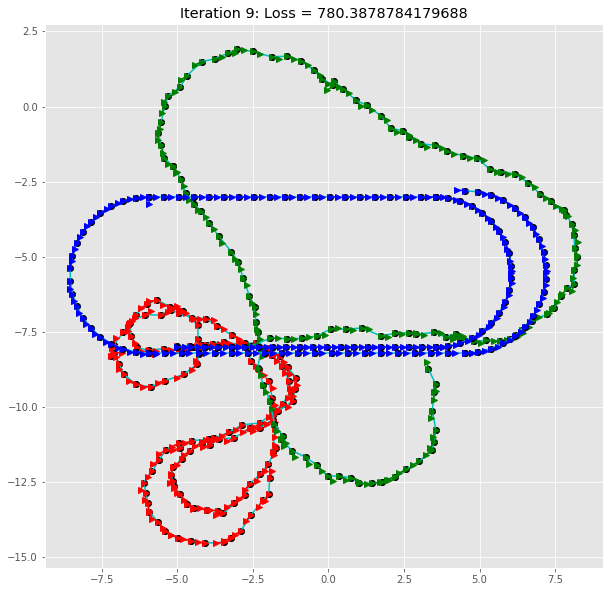

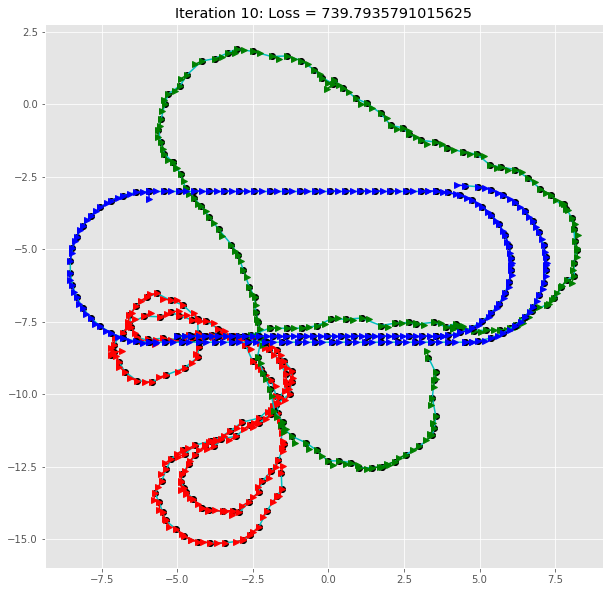

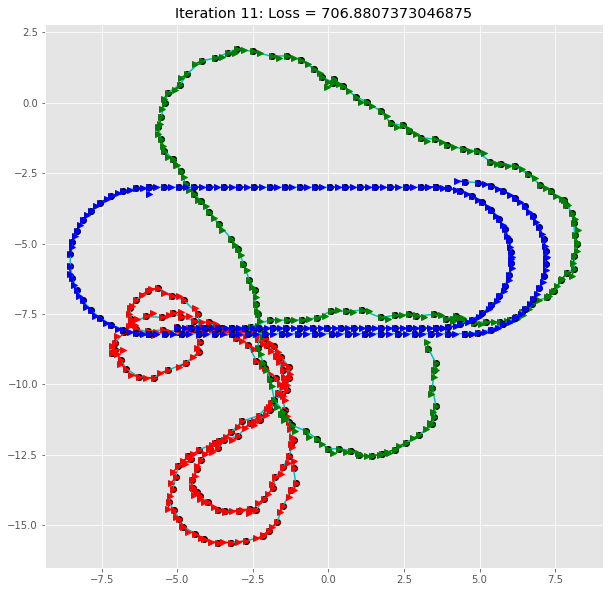

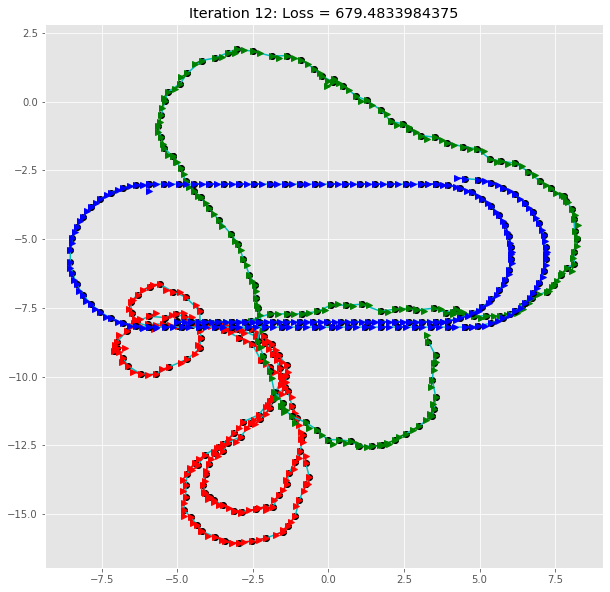

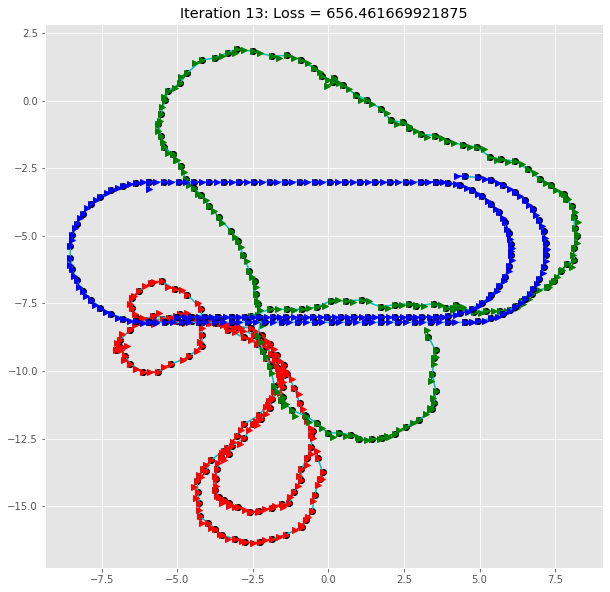

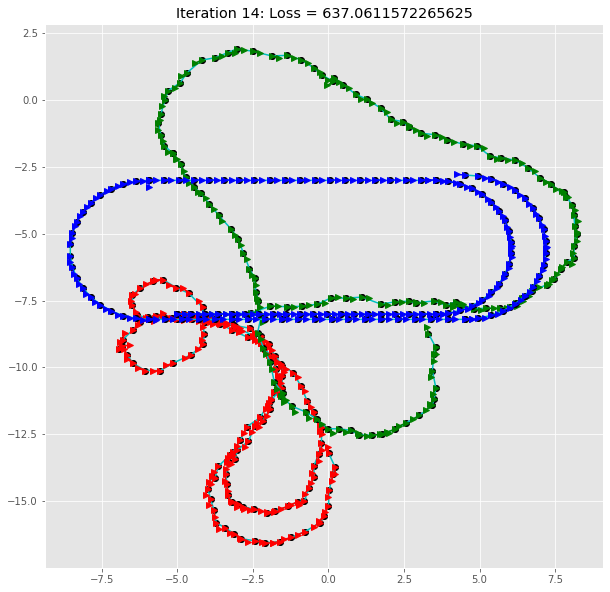

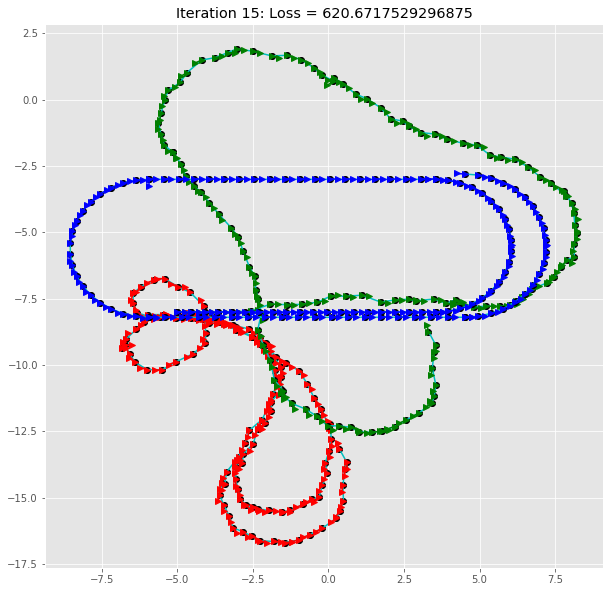

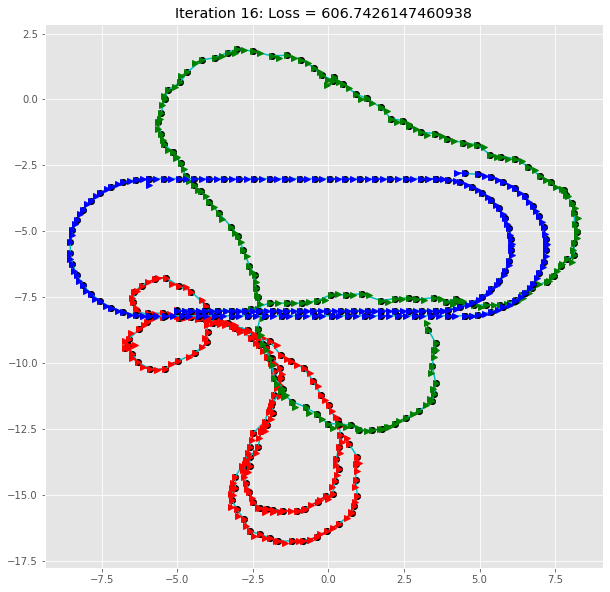

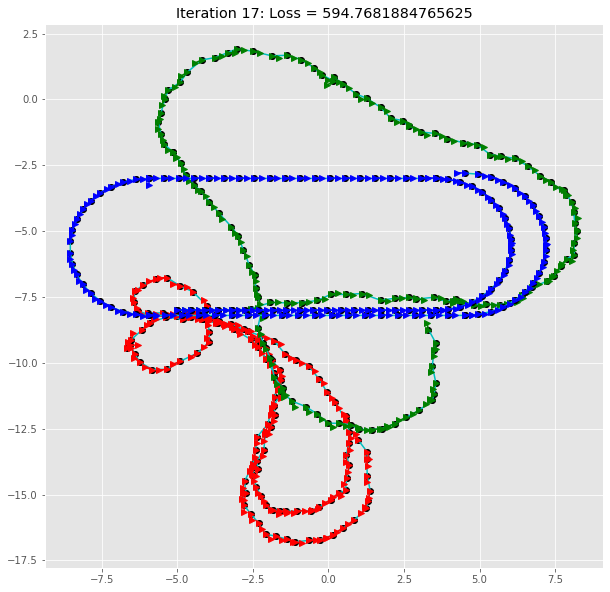

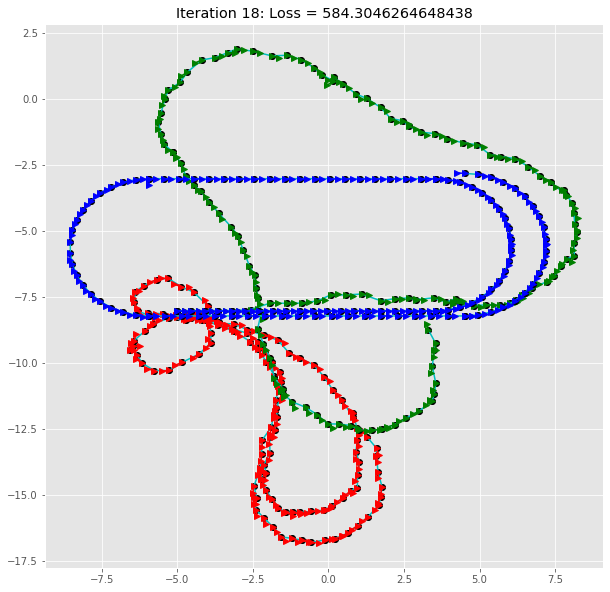

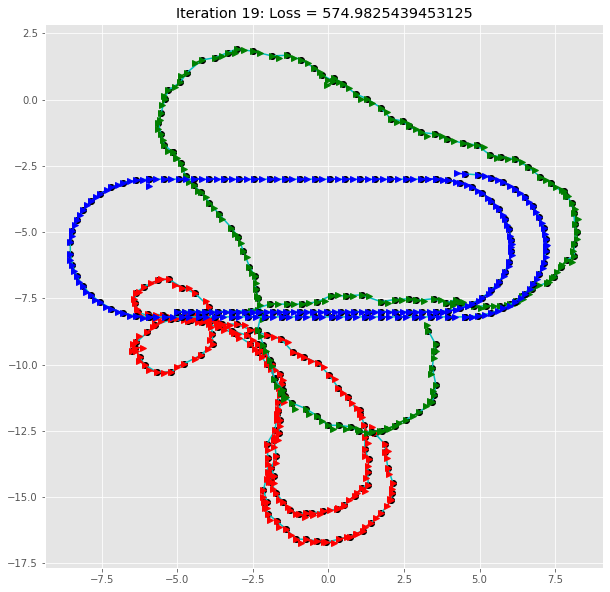

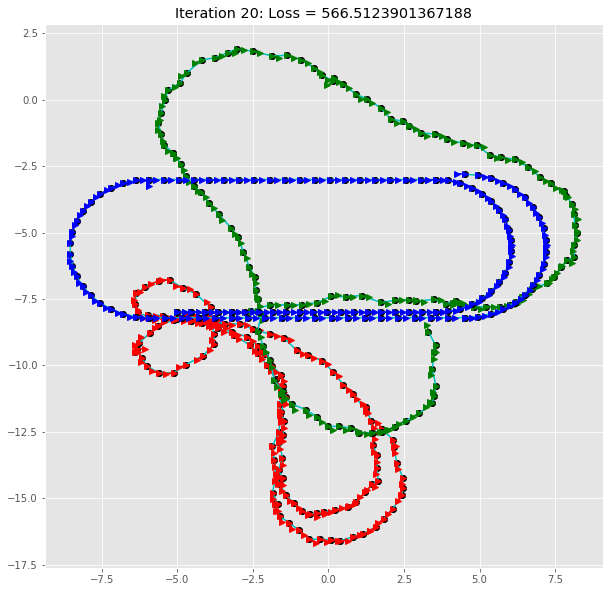

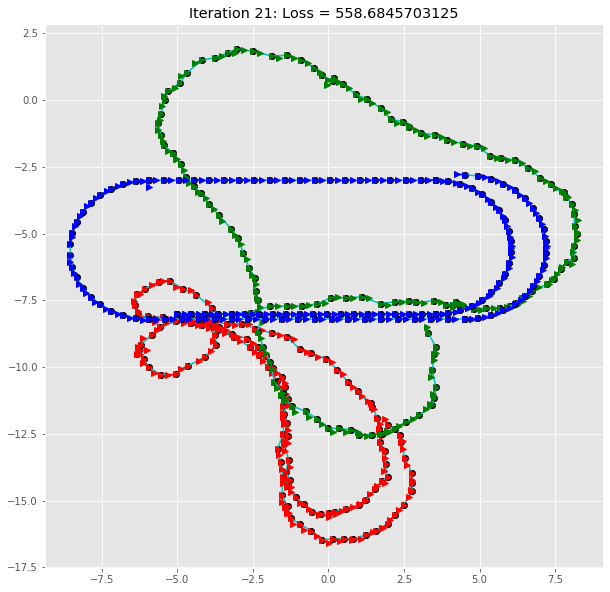

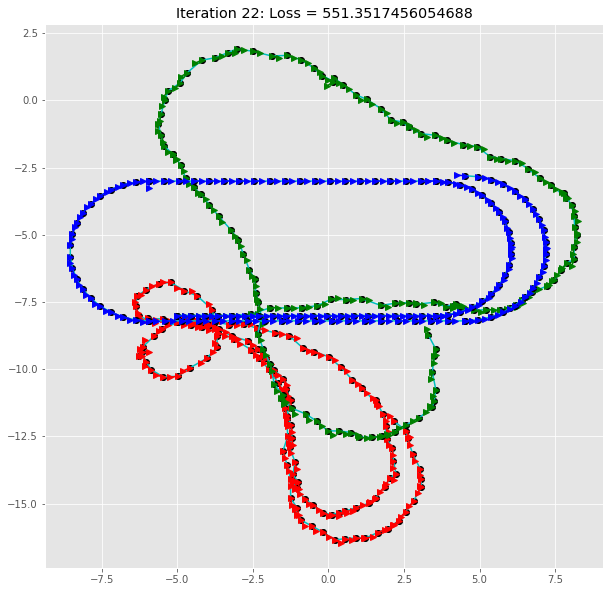

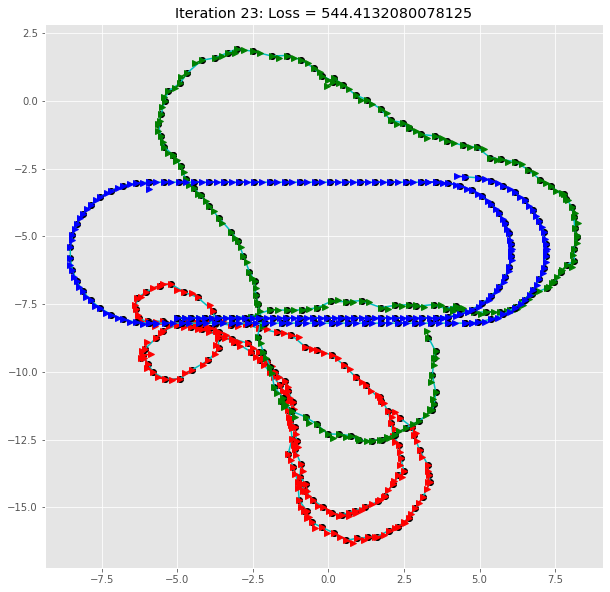

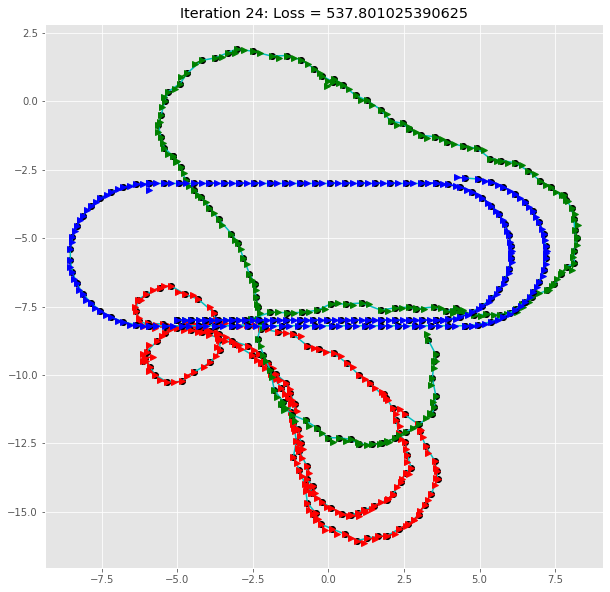

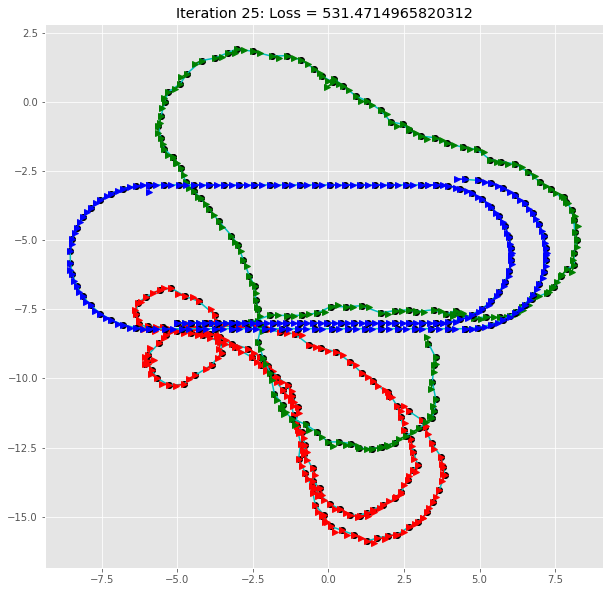

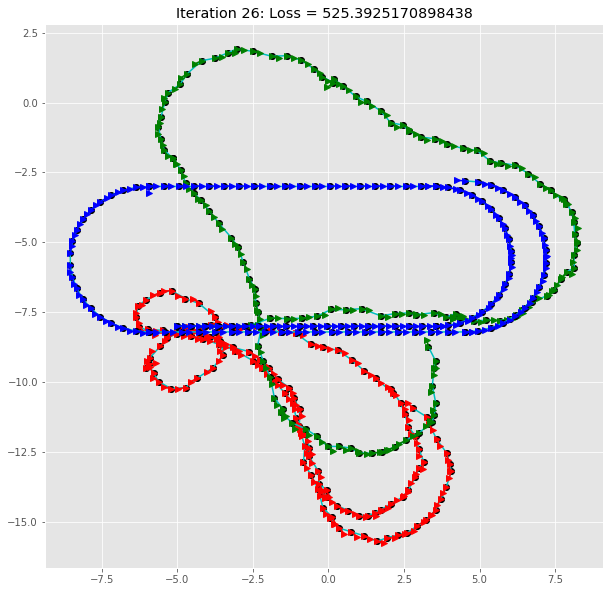

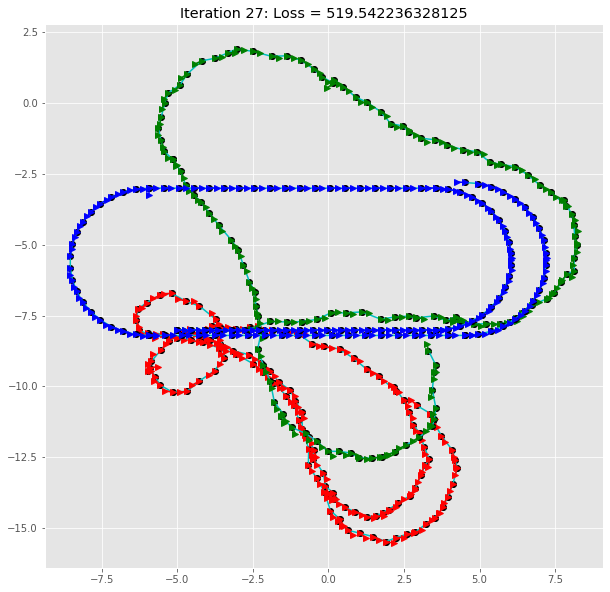

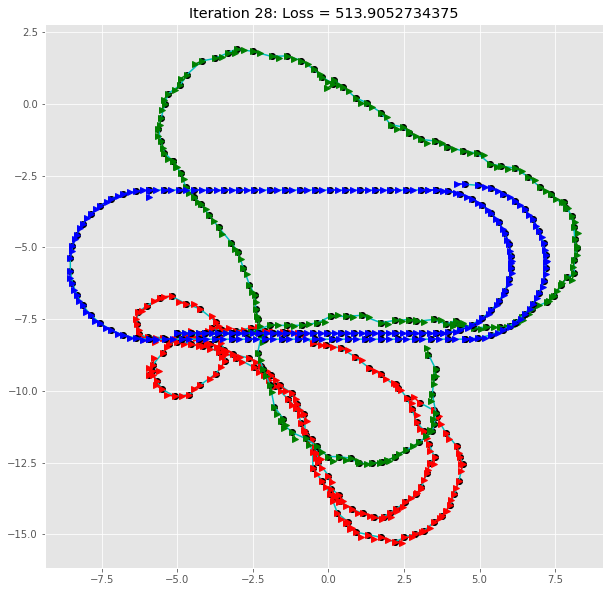

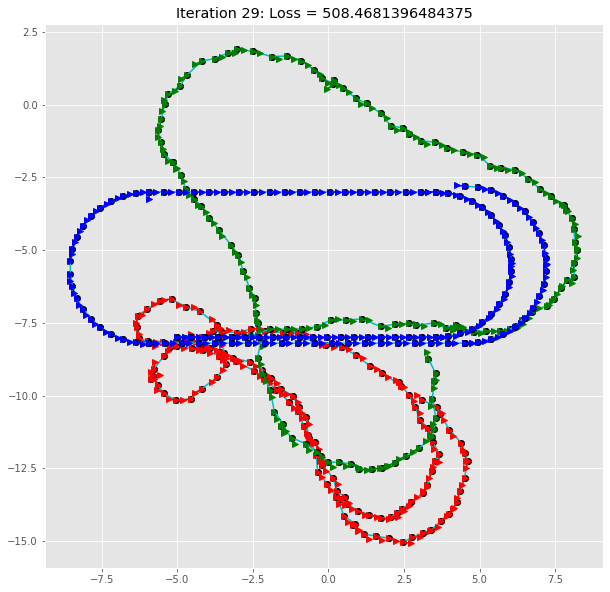

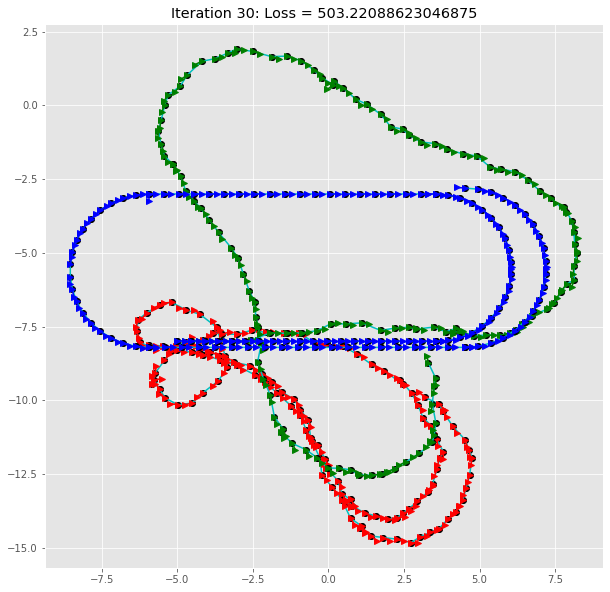

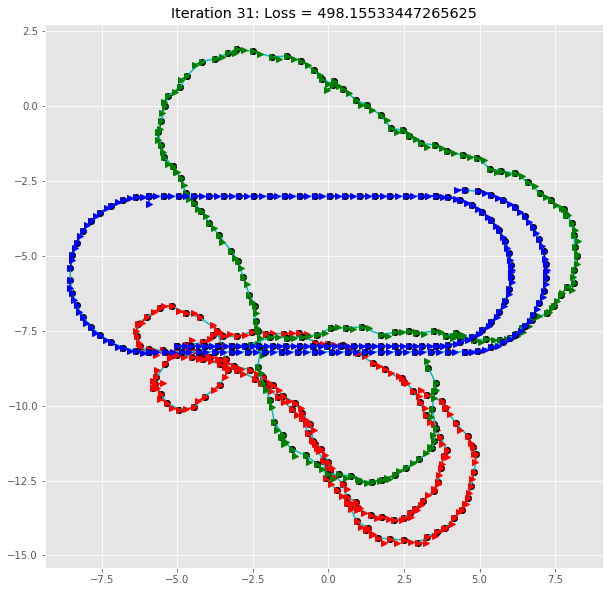

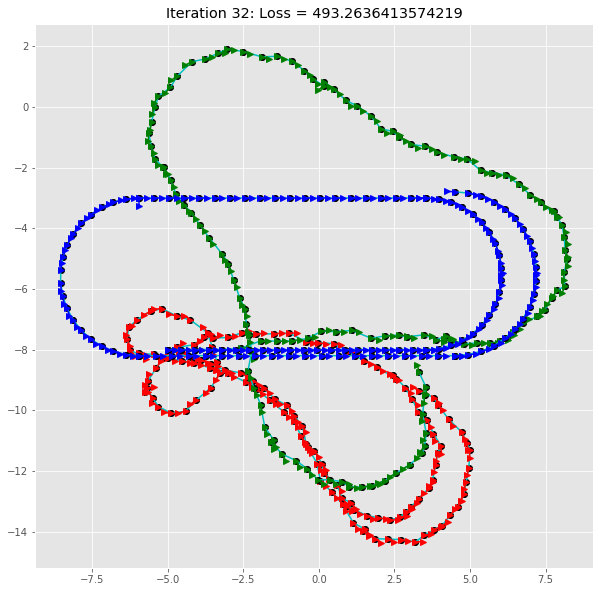

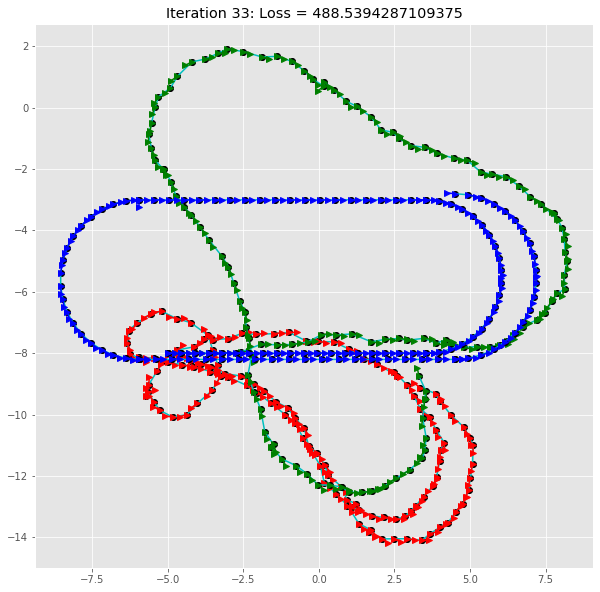

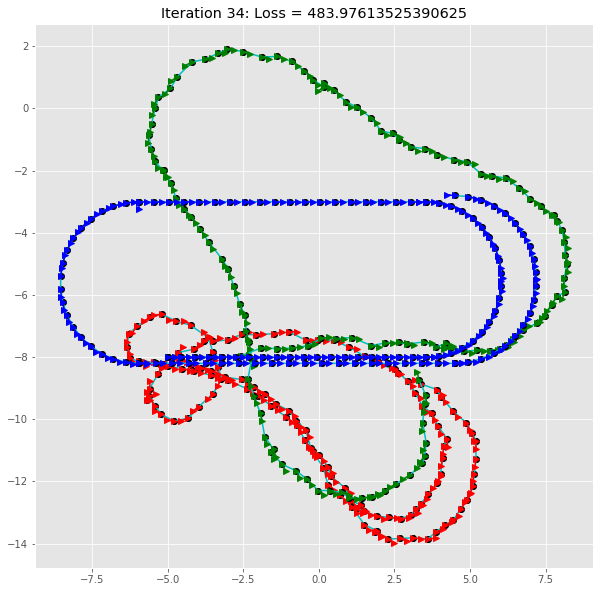

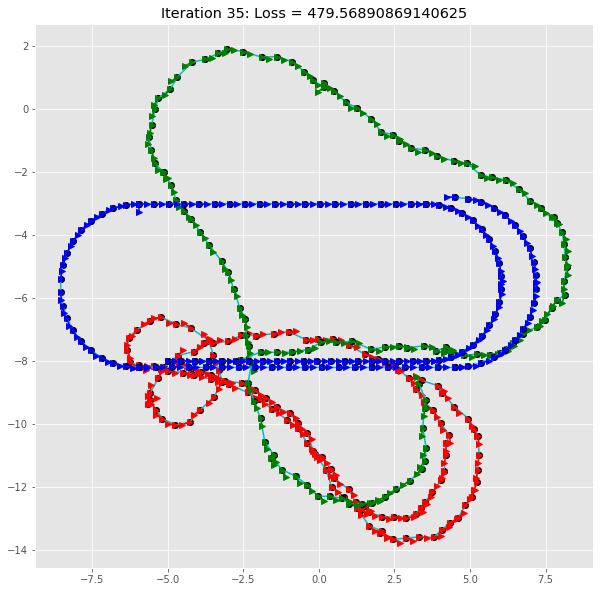

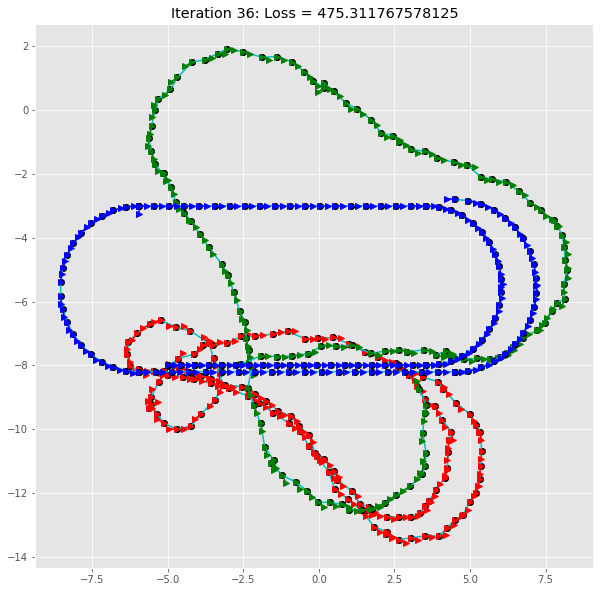

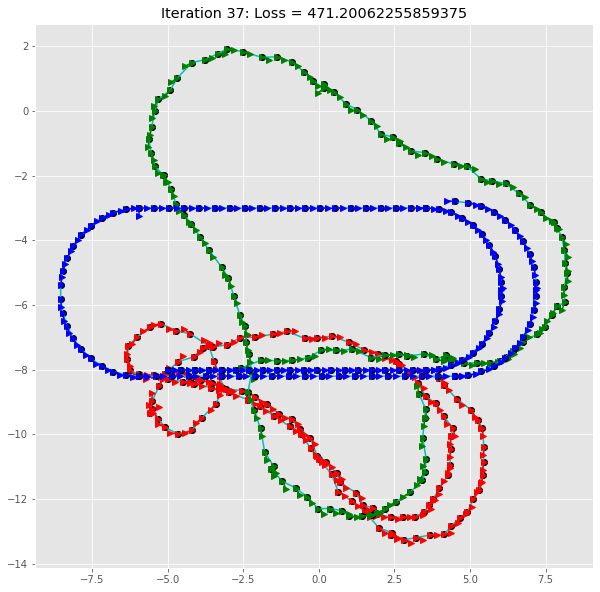

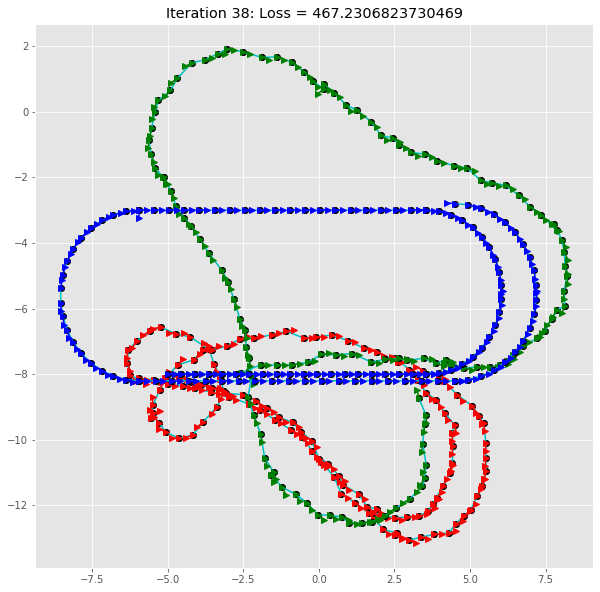

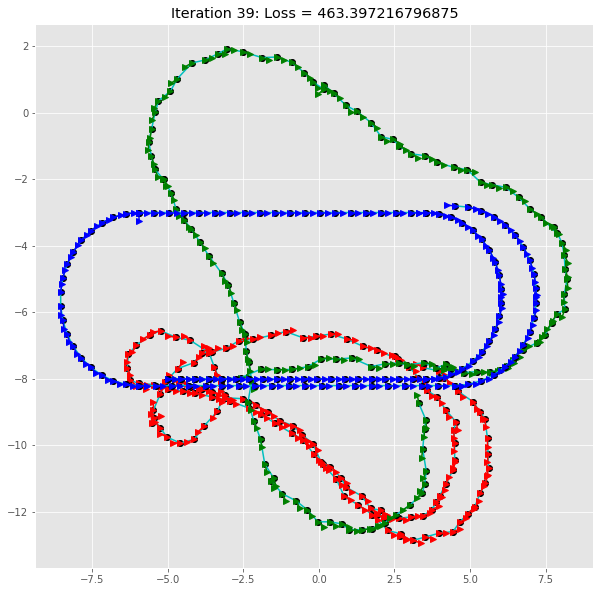

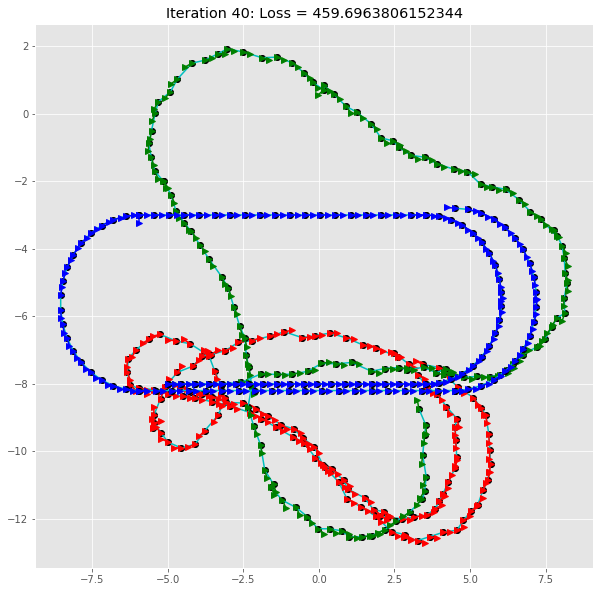

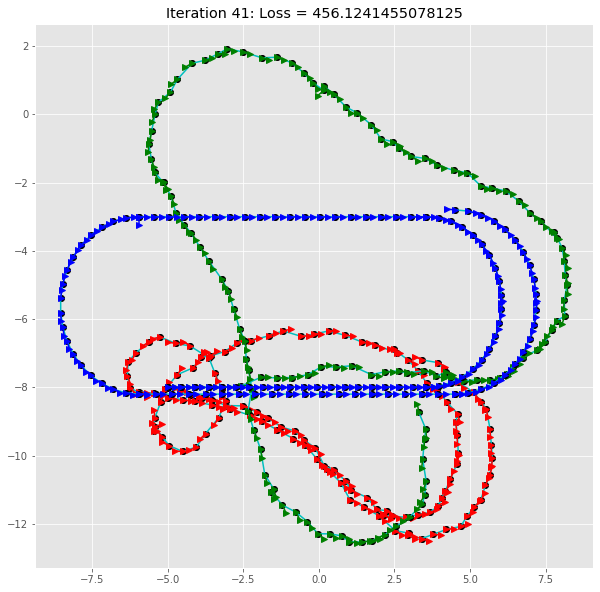

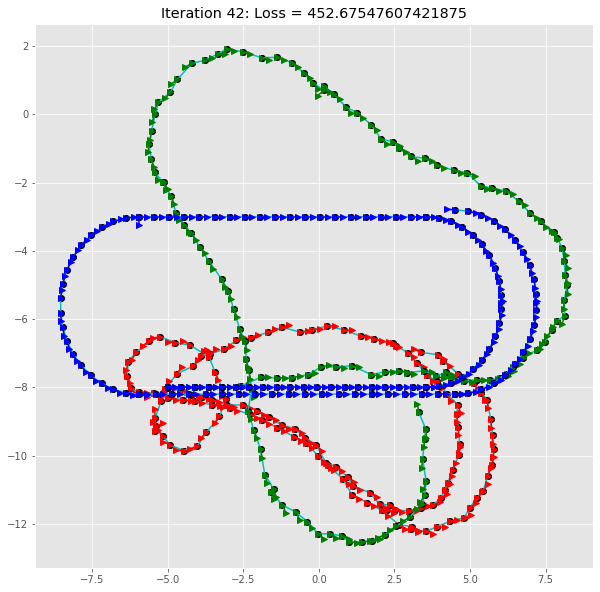

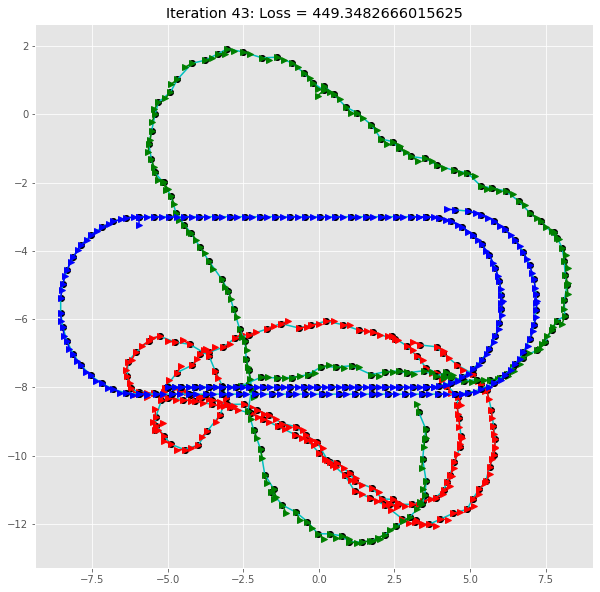

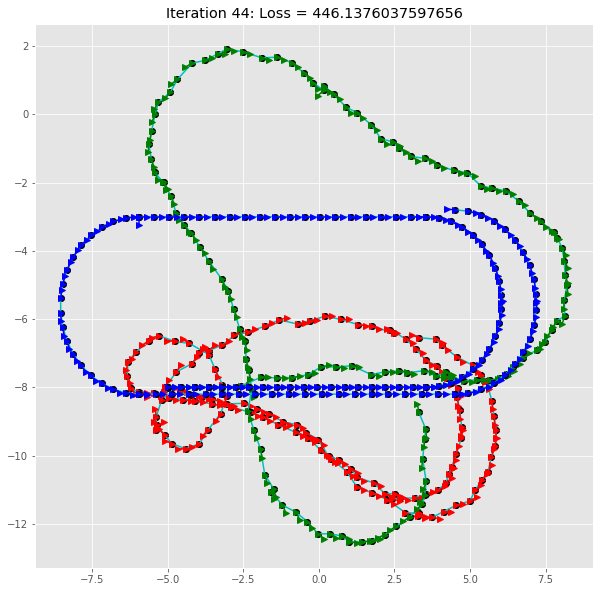

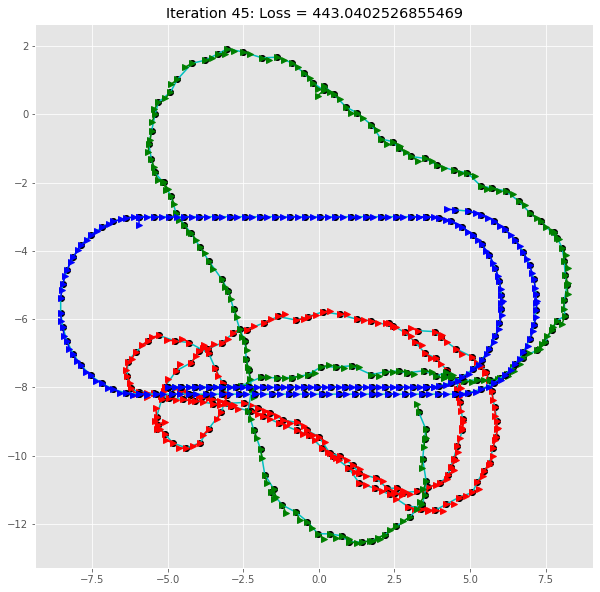

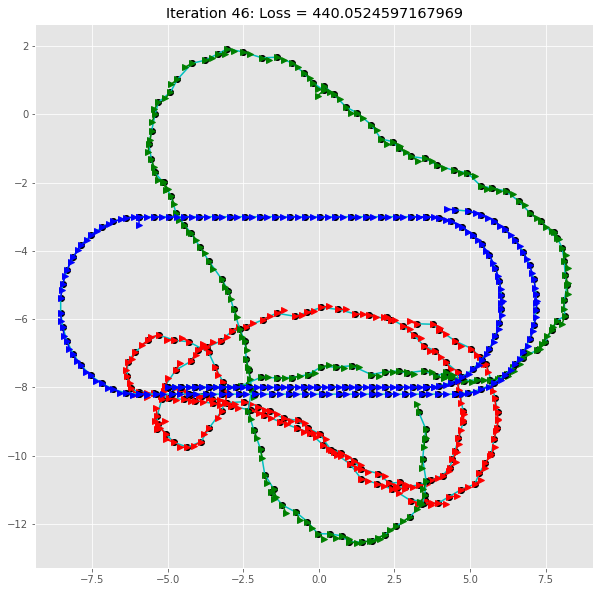

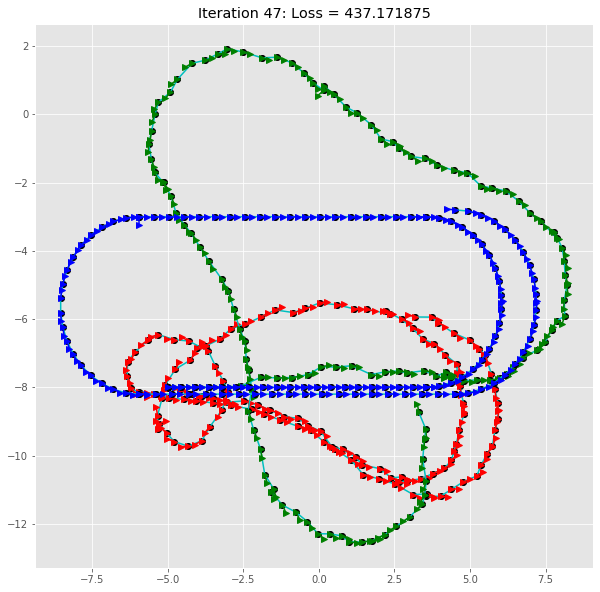

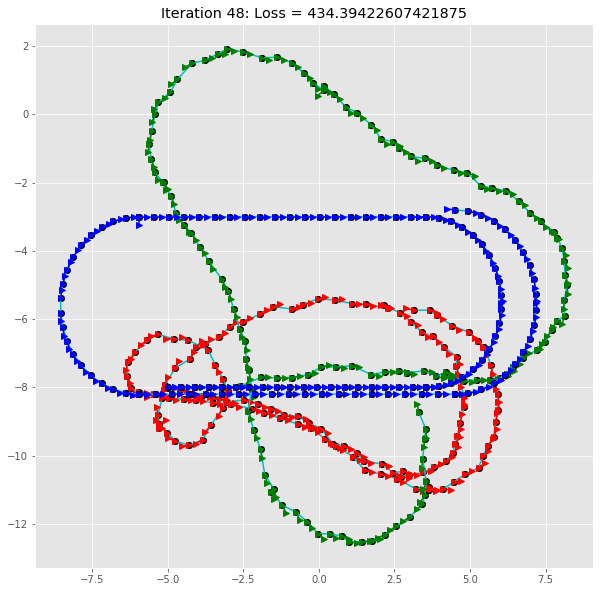

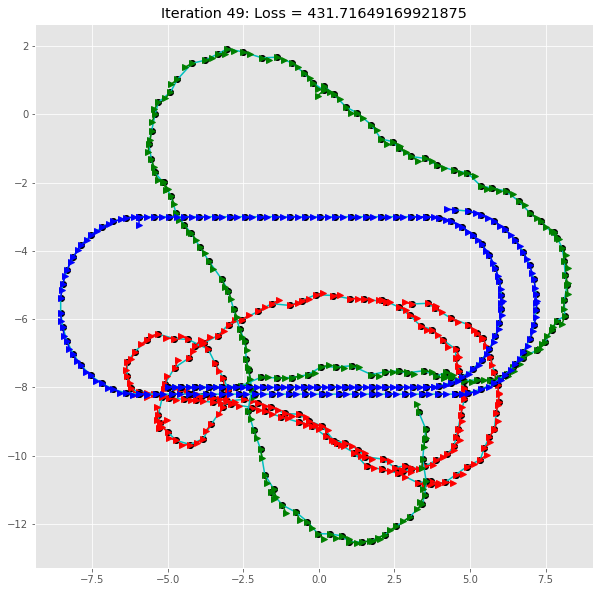

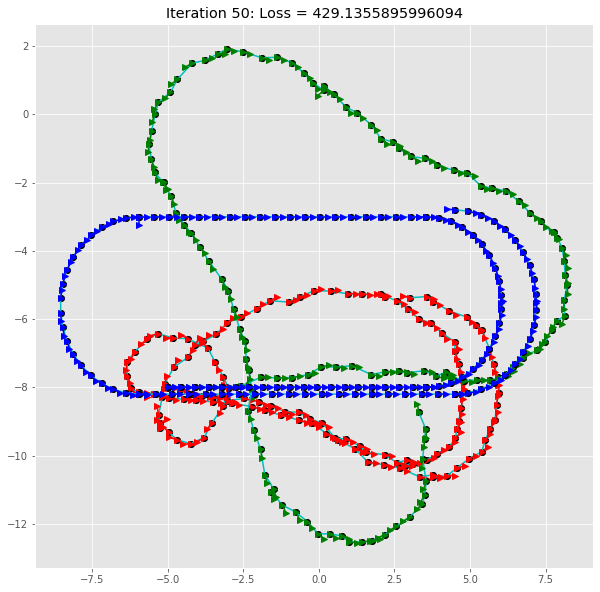

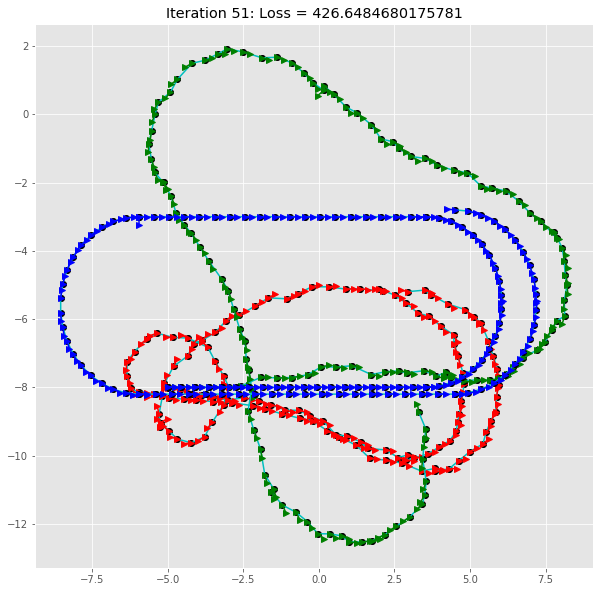

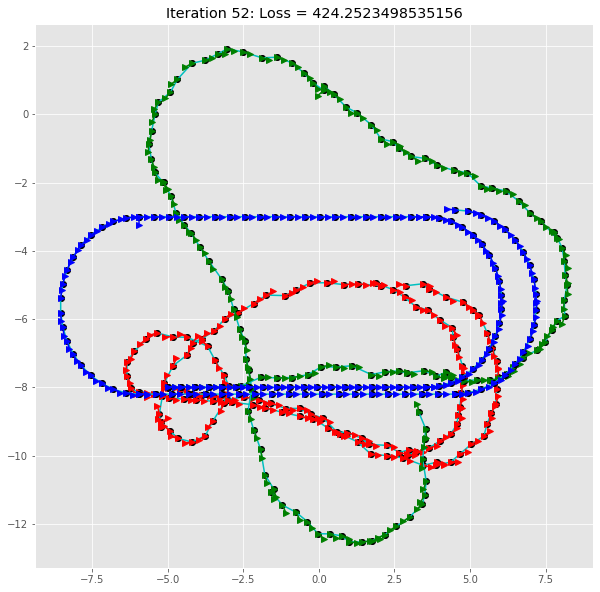

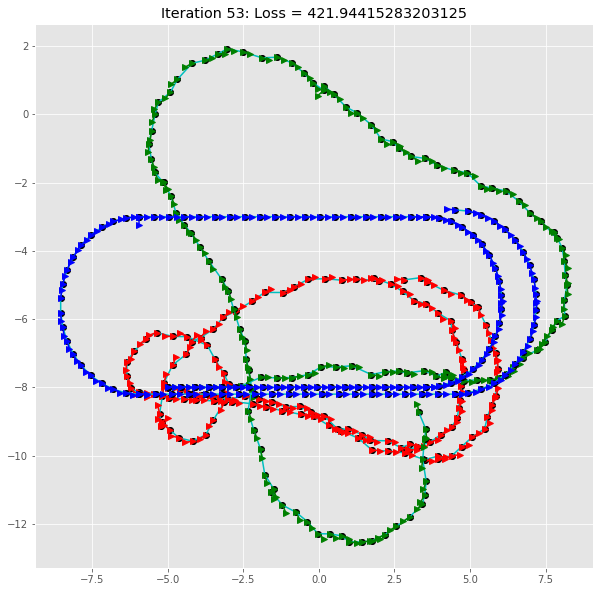

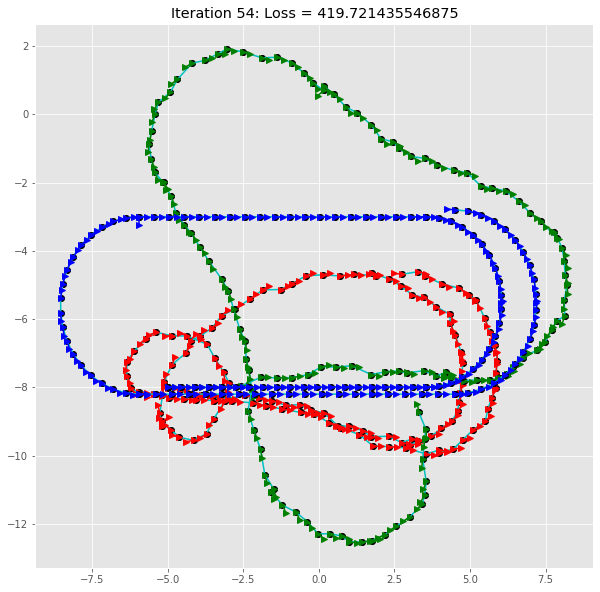

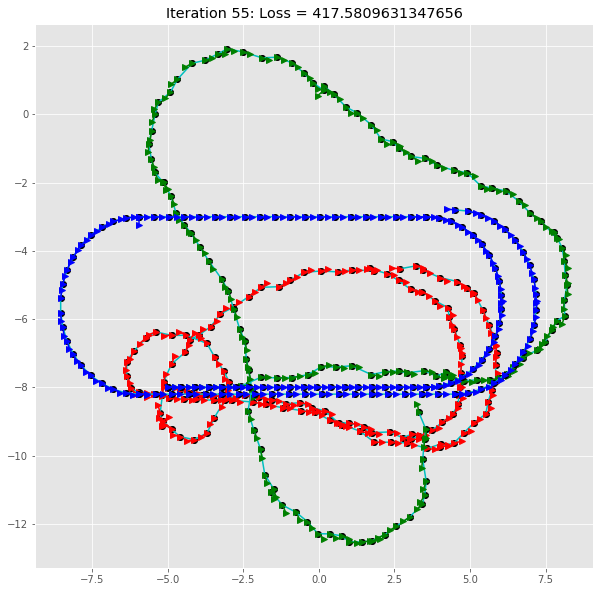

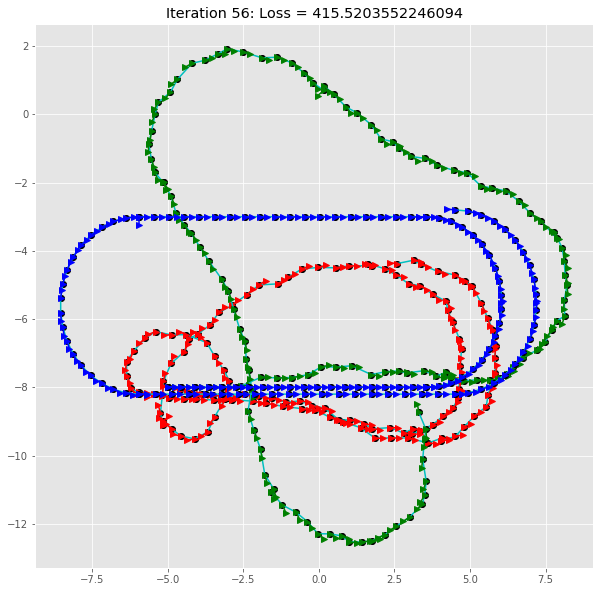

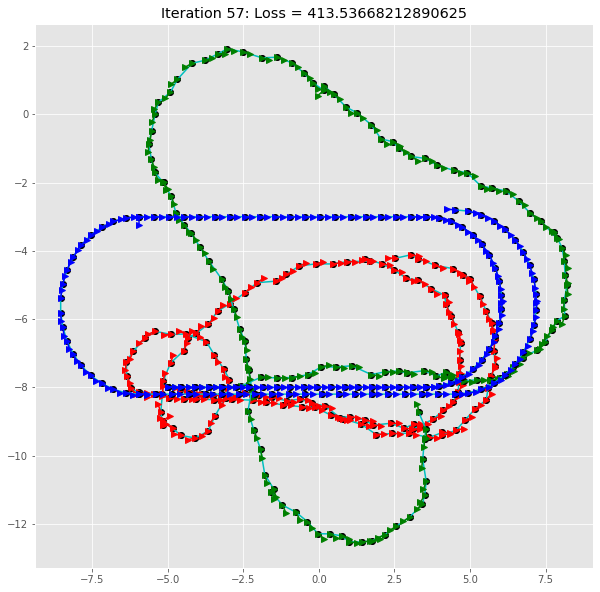

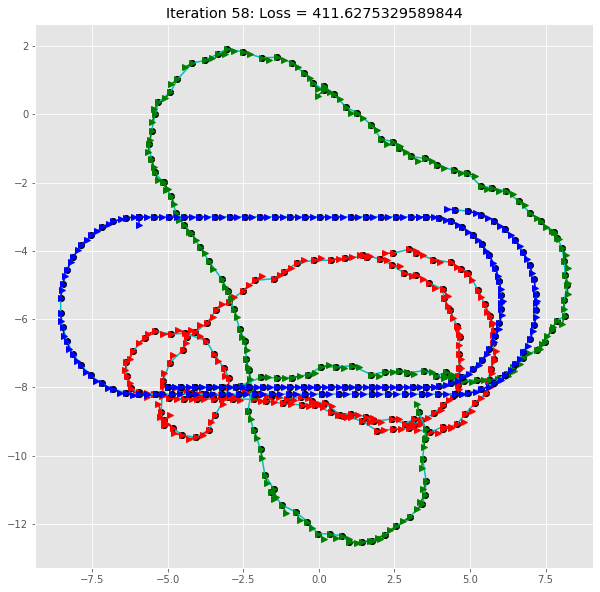

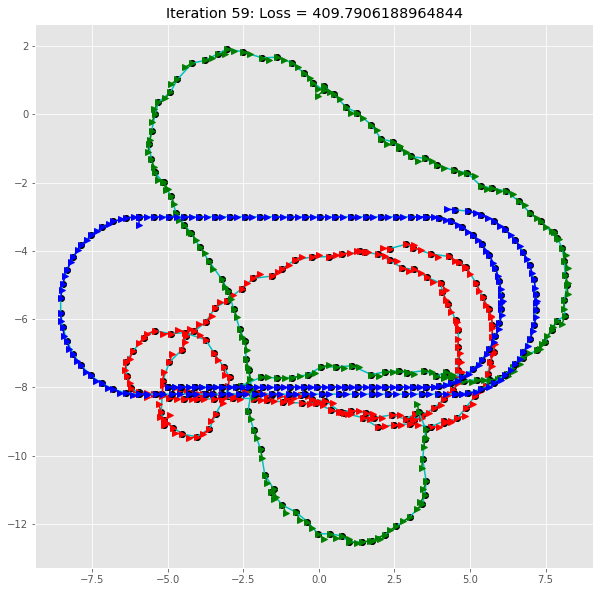

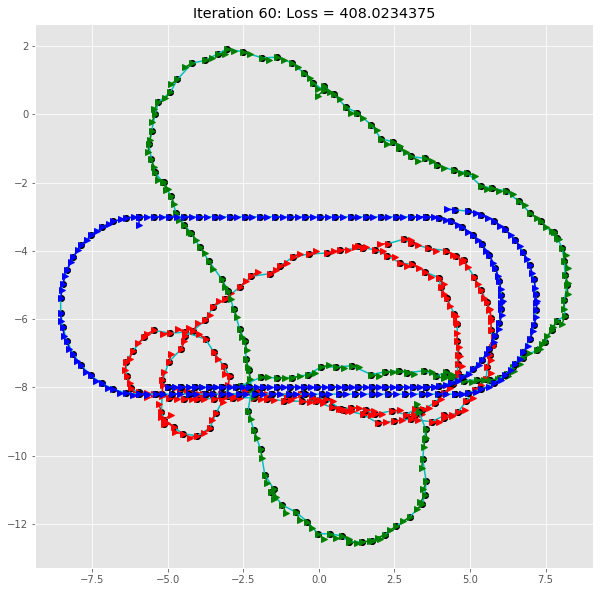

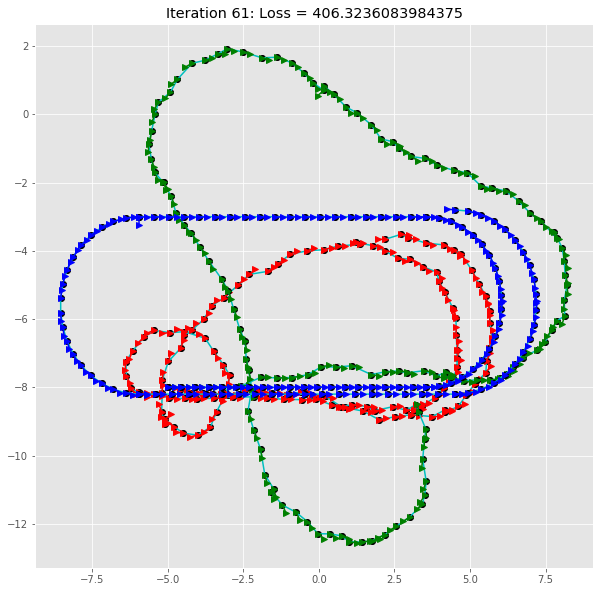

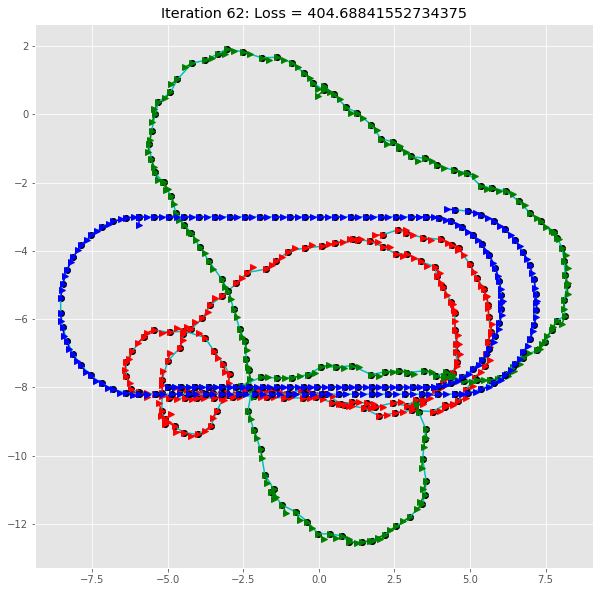

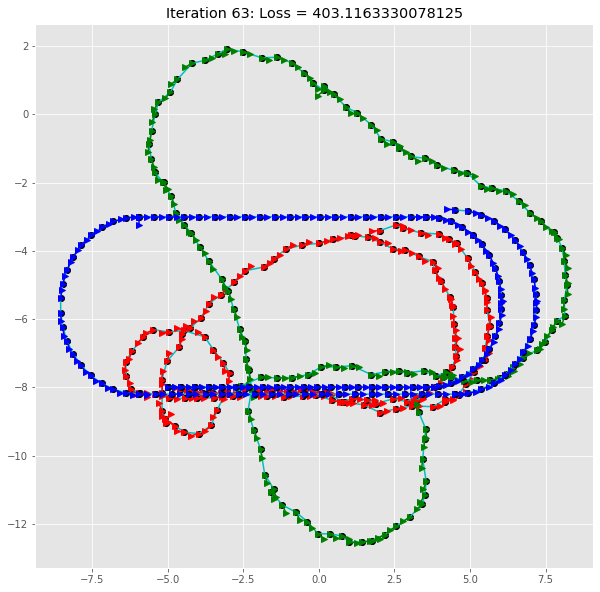

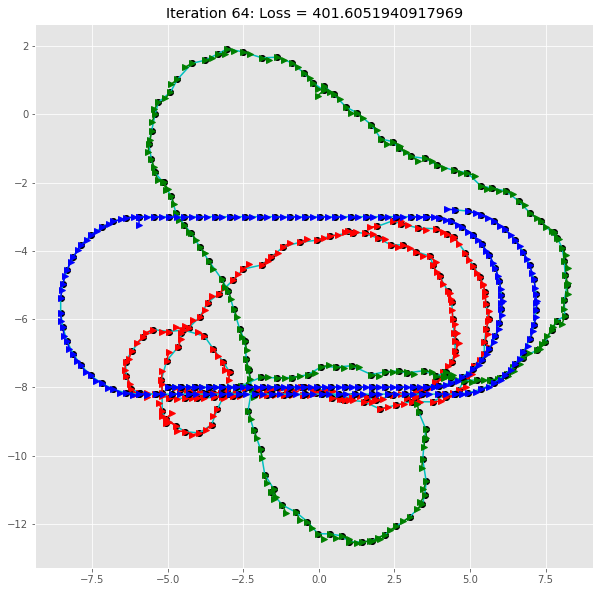

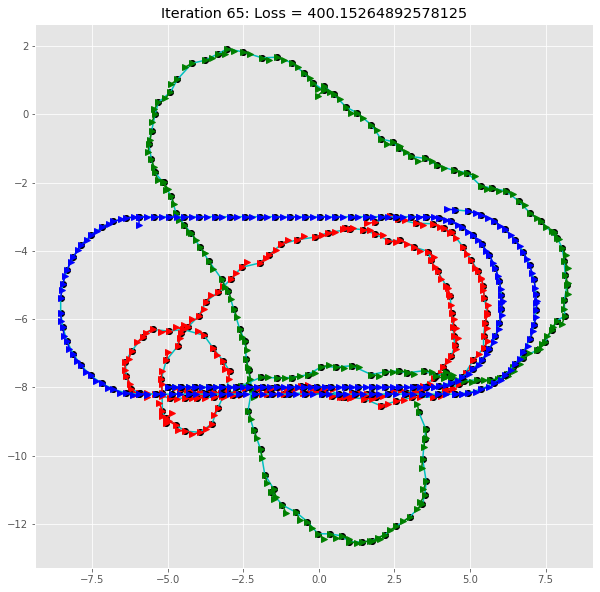

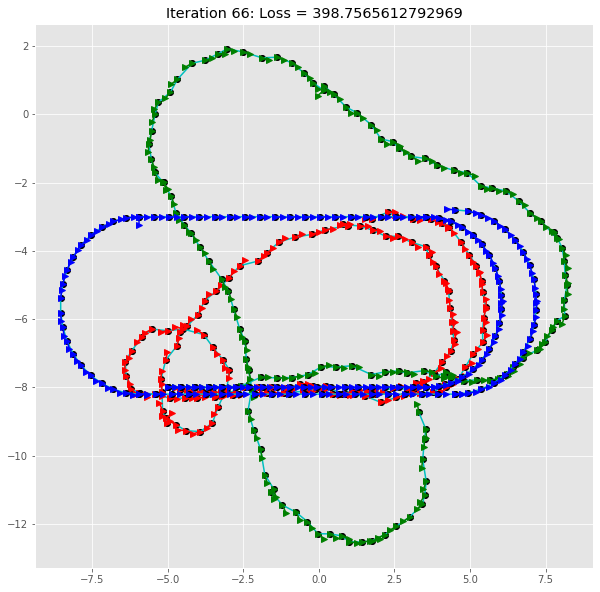

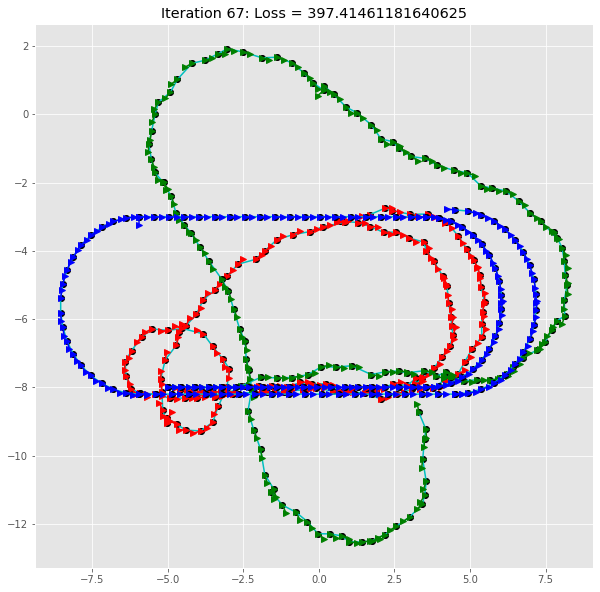

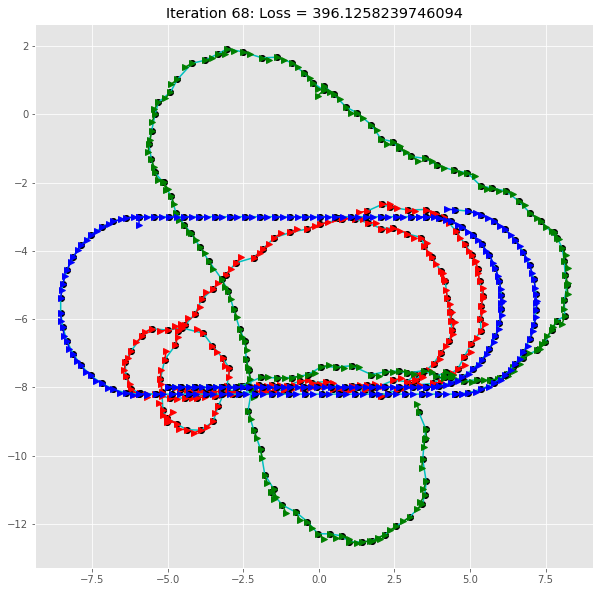

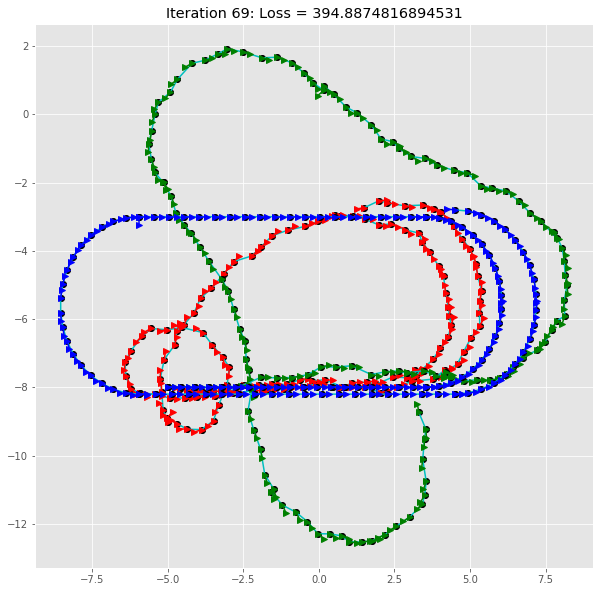

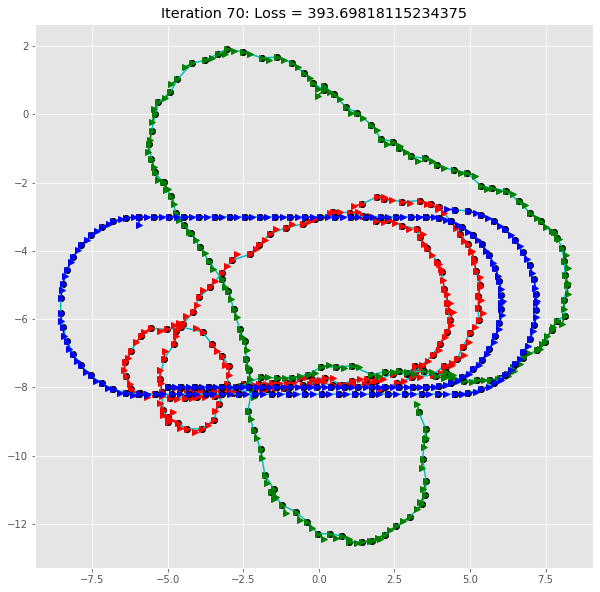

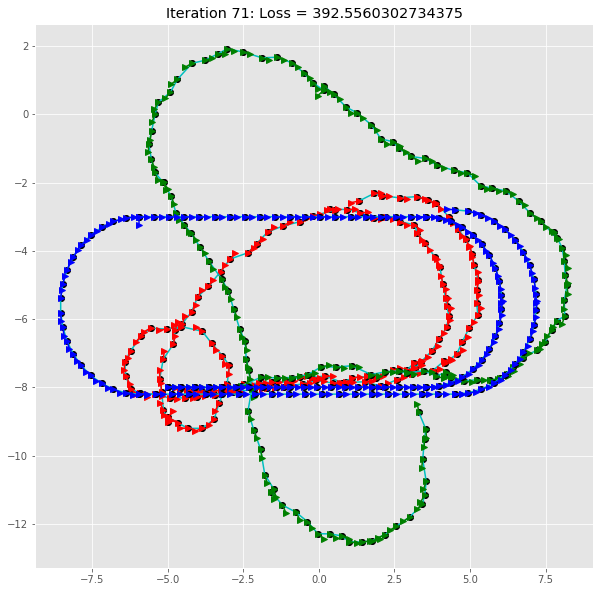

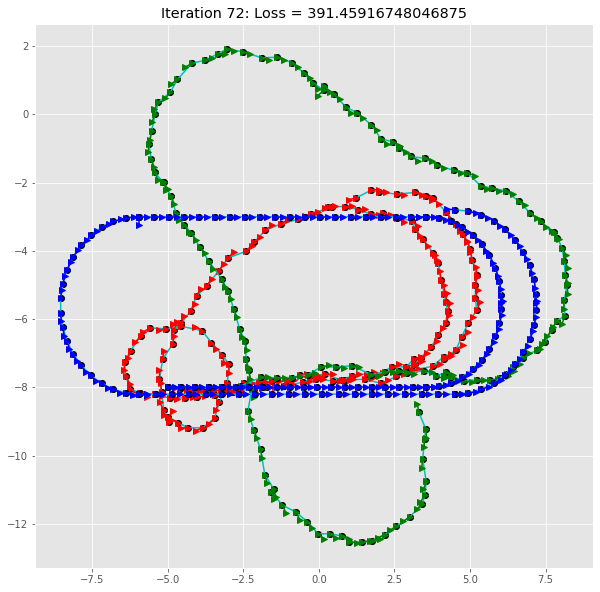

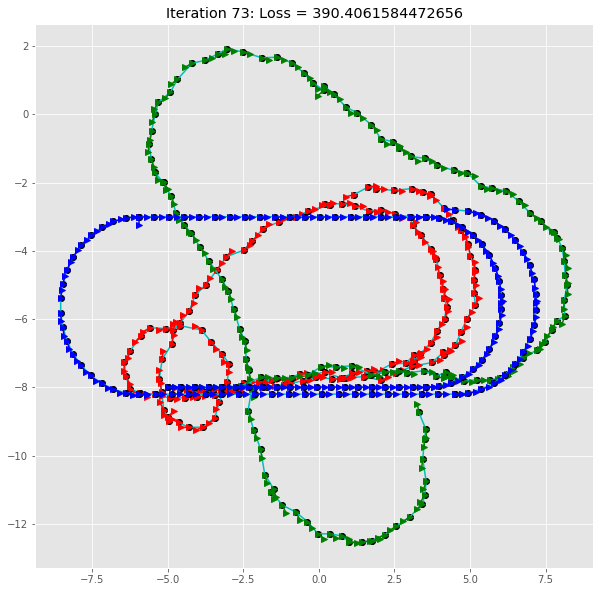

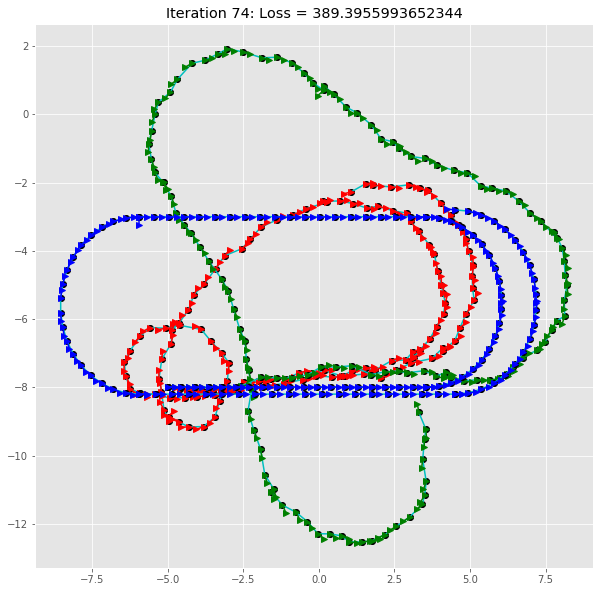

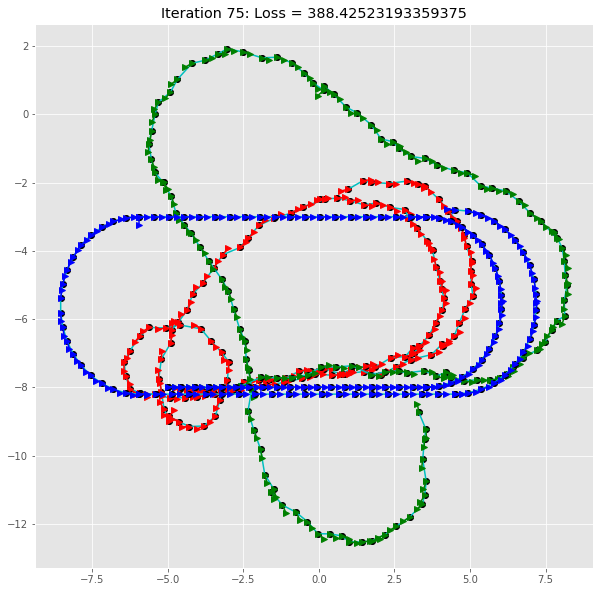

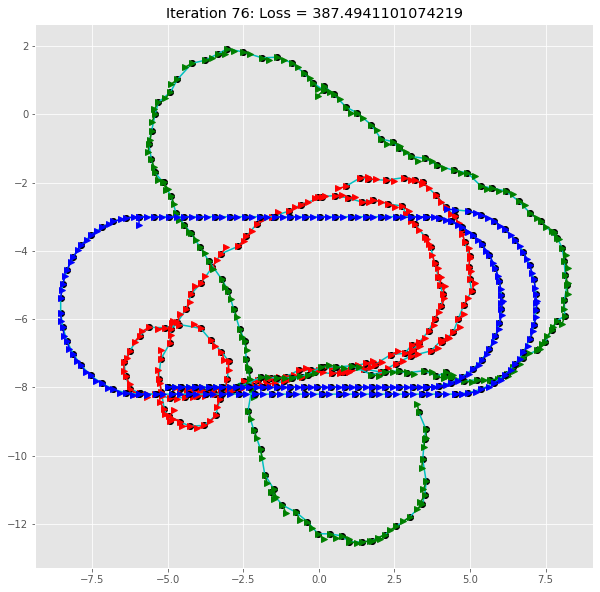

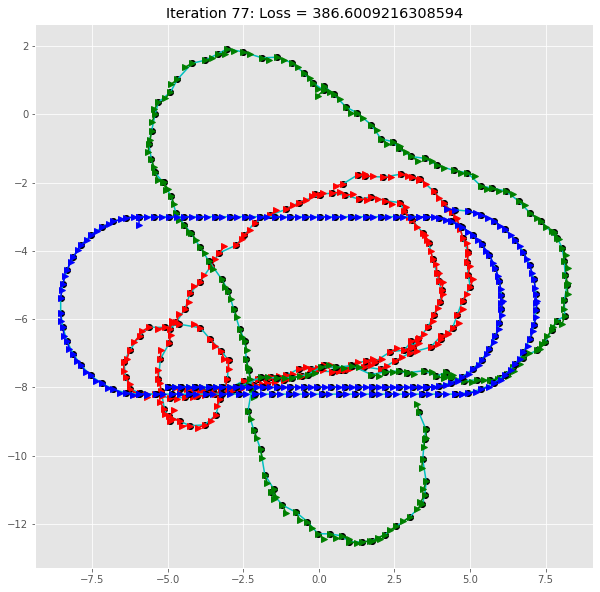

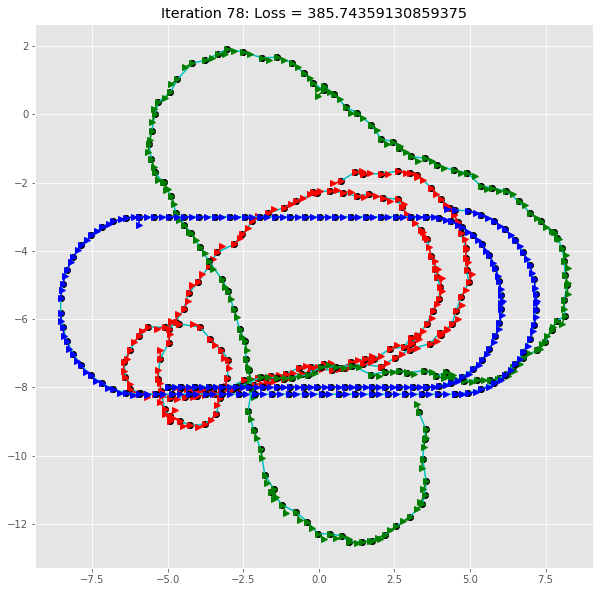

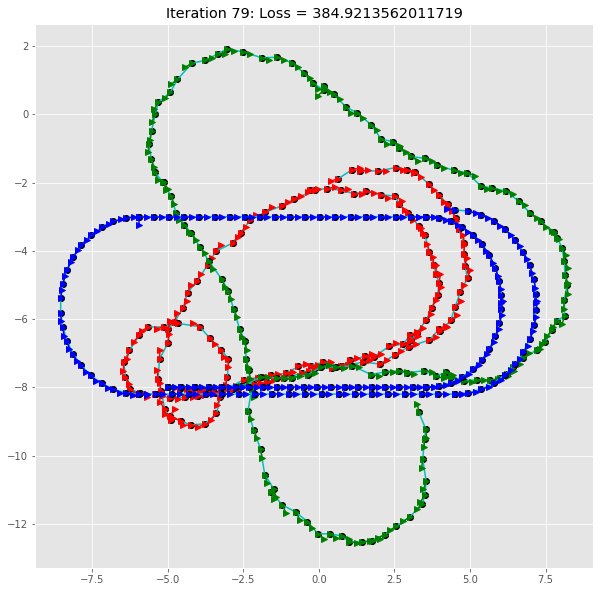

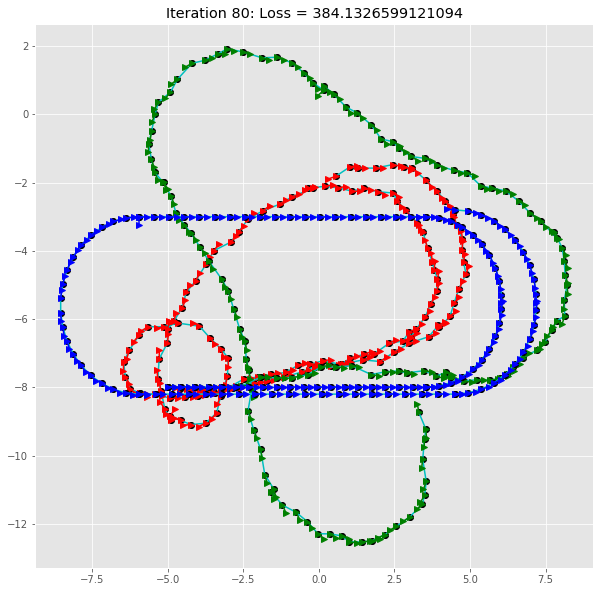

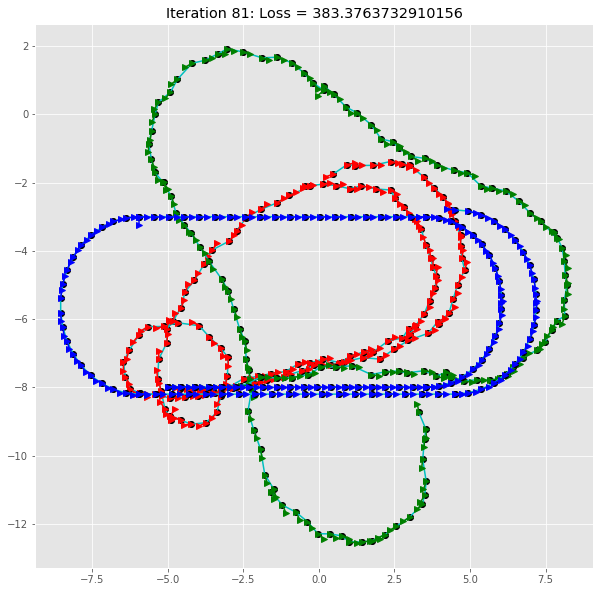

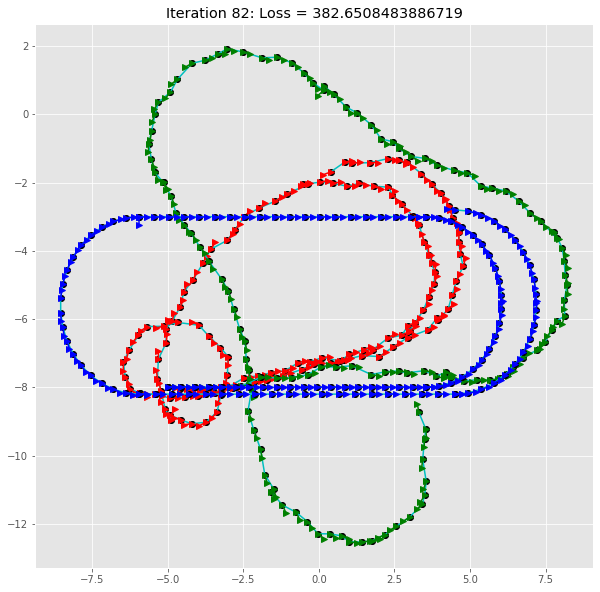

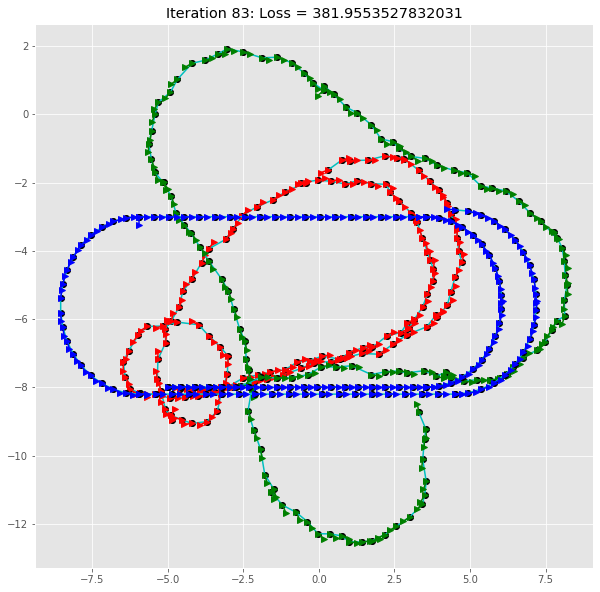

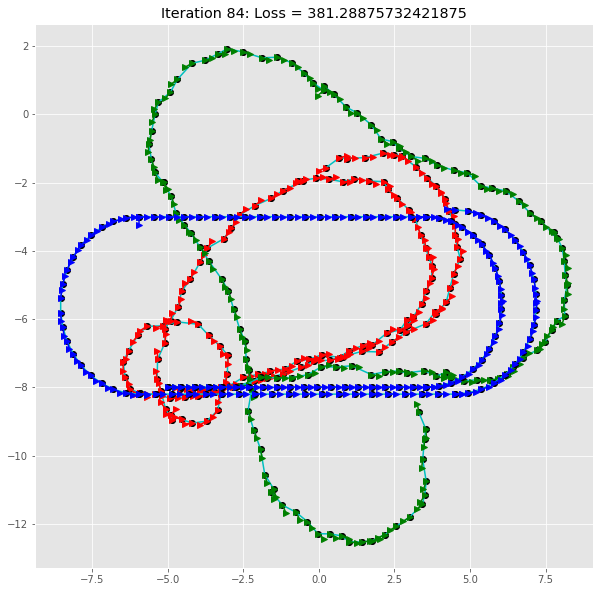

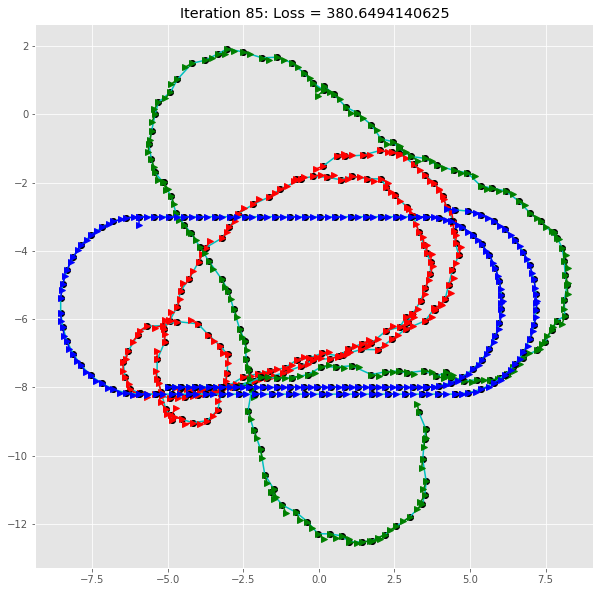

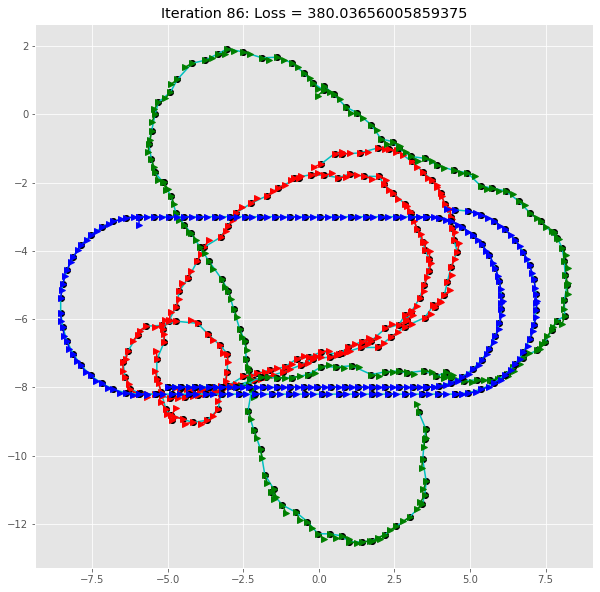

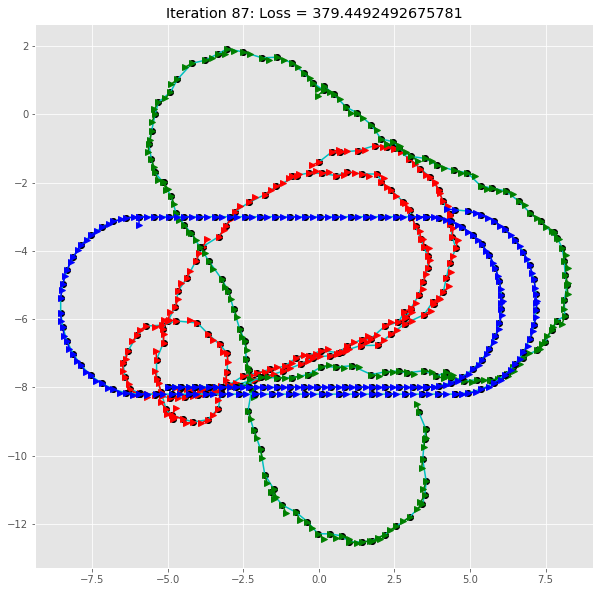

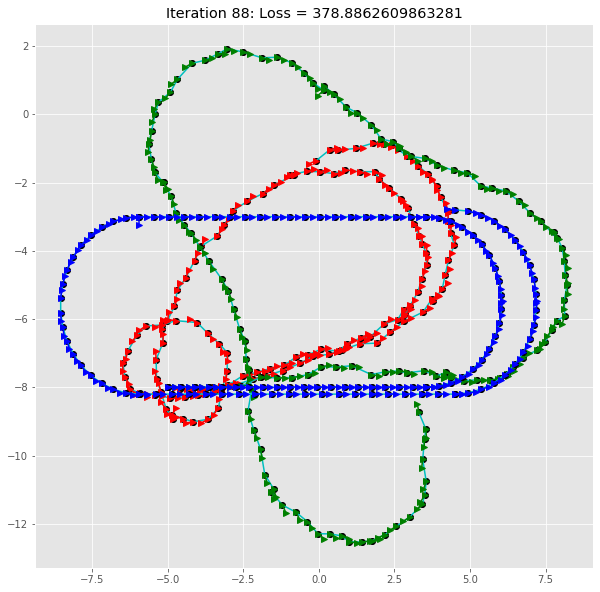

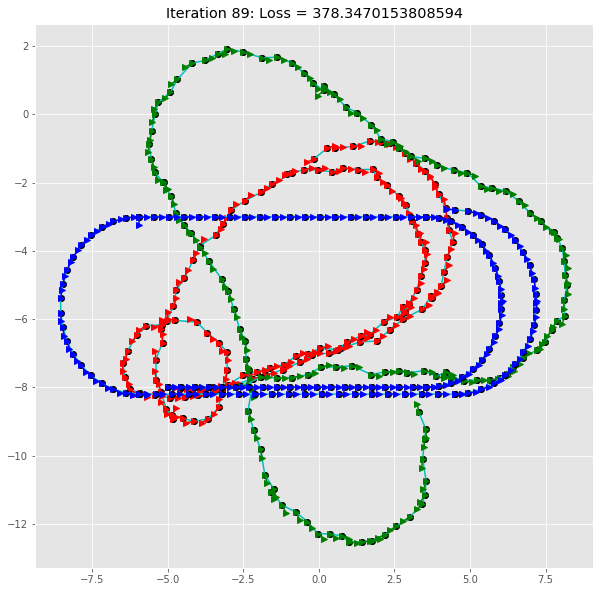

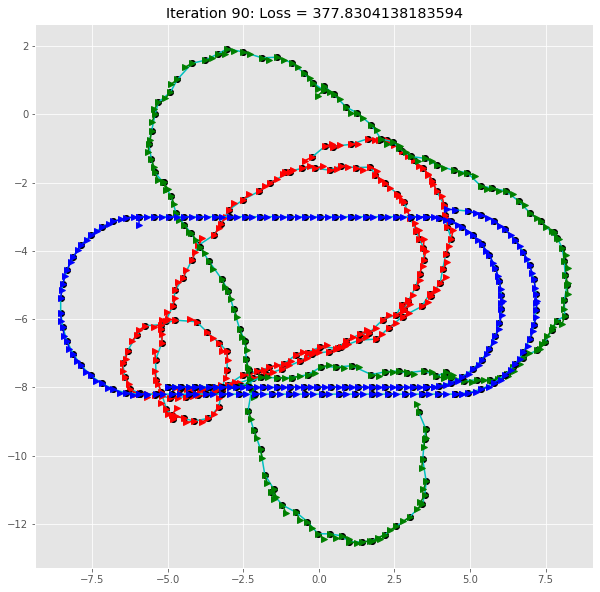

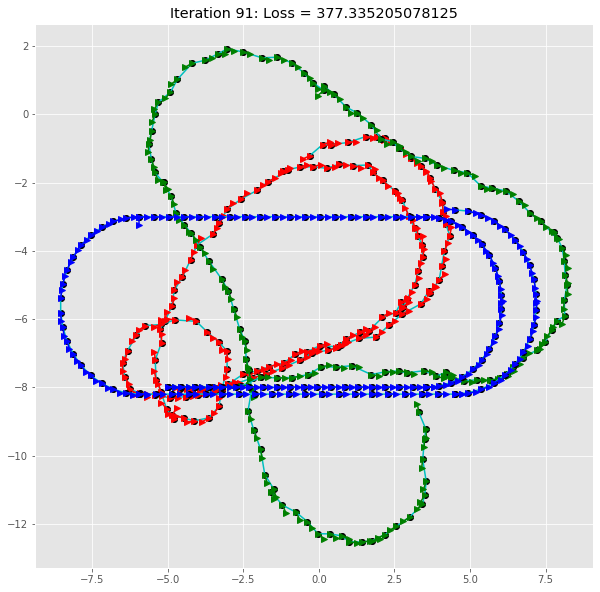

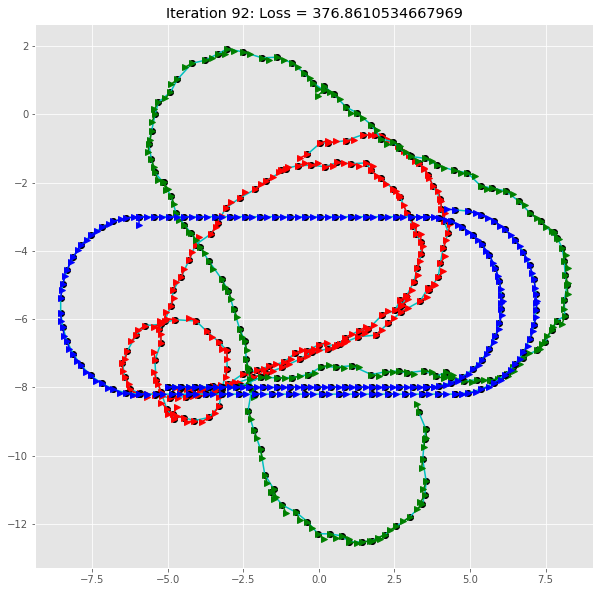

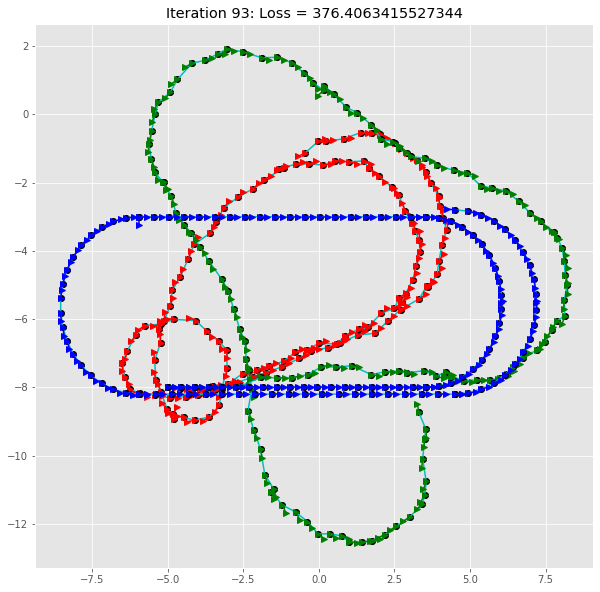

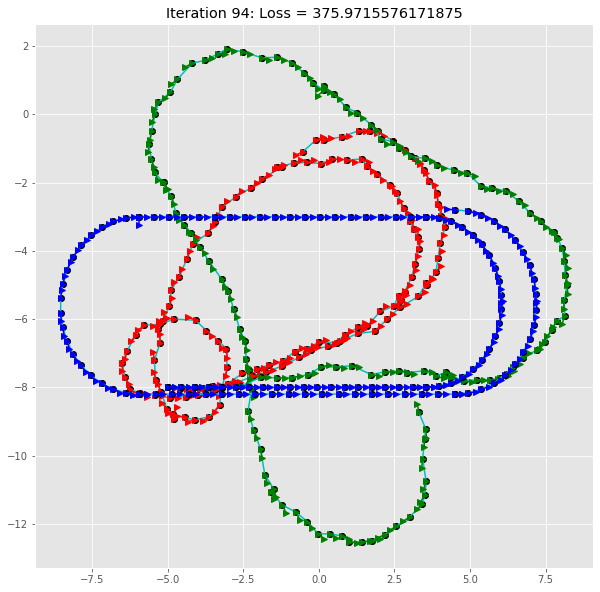

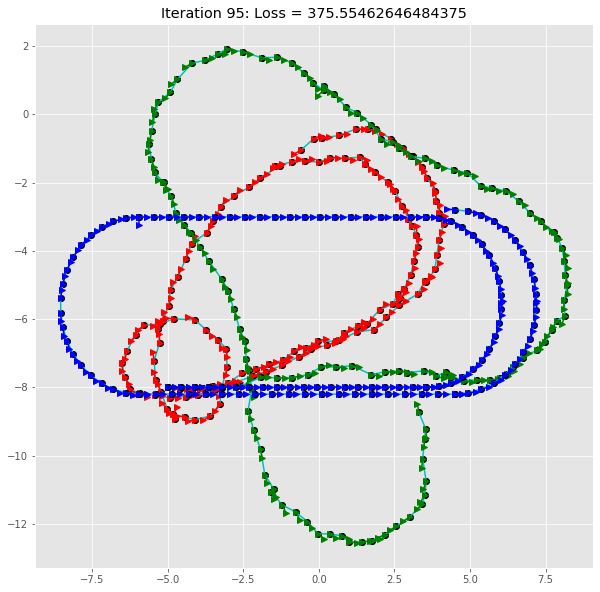

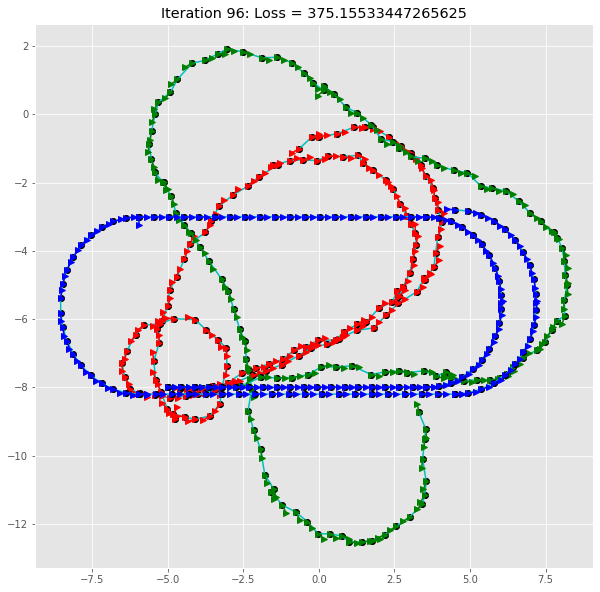

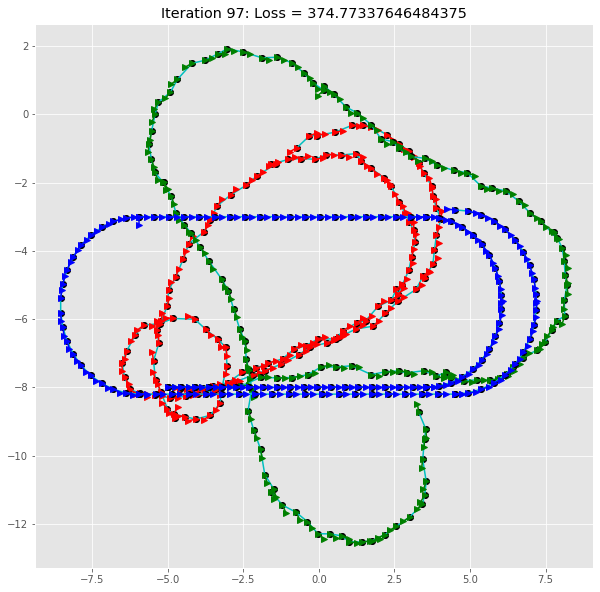

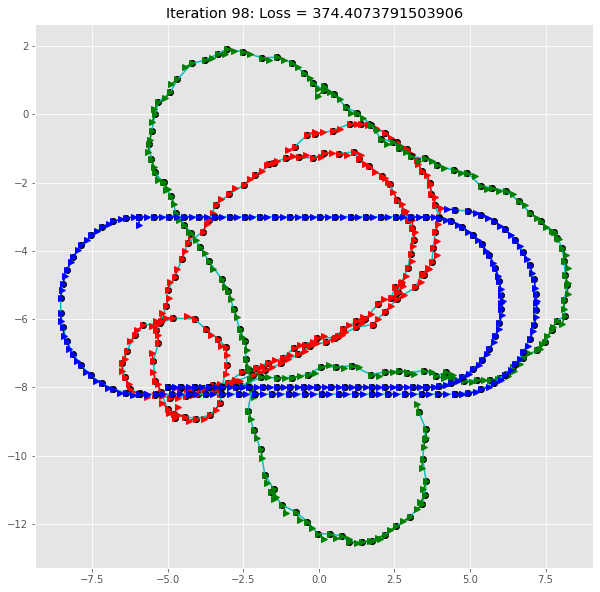

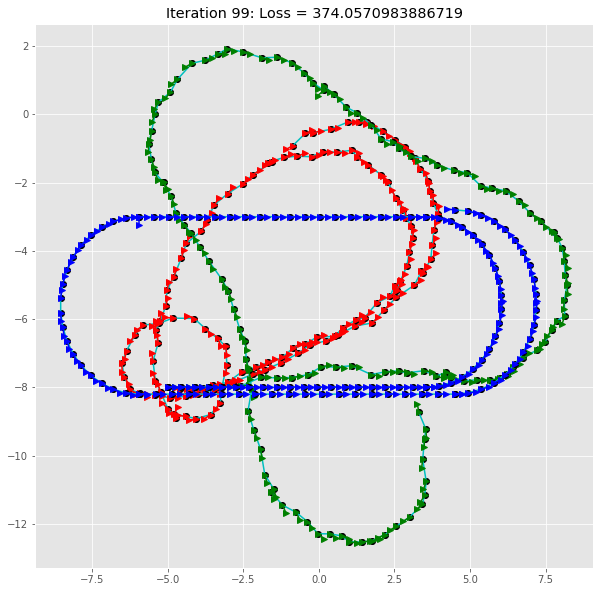

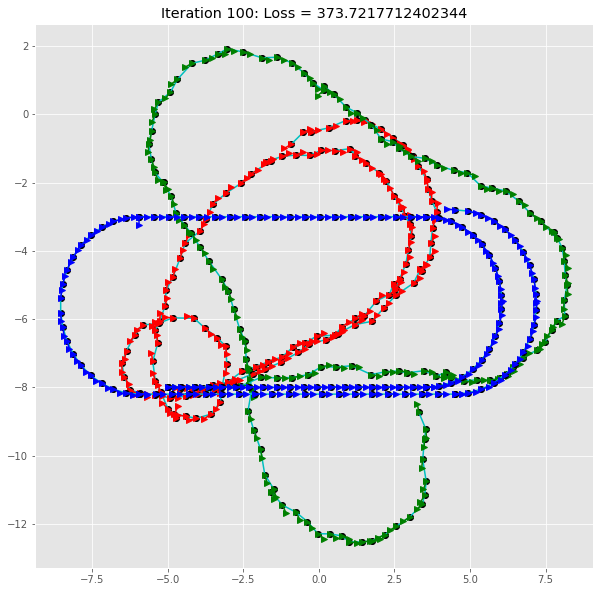

In [11]:
def weights_matrix(graph):
    WEIGHT_ODOMETRY, WEIGHT_LOOP, WEIGHT_ANCHOR = 400, 1000, 2000
    diagonal = [WEIGHT_ANCHOR] * 3
    for edge in graph.edges:
        diagonal.extend([WEIGHT_ODOMETRY if abs(edge.u - edge.v) == 1 else WEIGHT_LOOP] * 3)
    return jnp.diag(jnp.array(diagonal))

weights = weights_matrix(graph)


def loss_fn(nodes, graph):
    f = residual(nodes, graph)
    return 0.5 * f.T @ weights @ f


def optimise(graph, *, num_iters=100, lm_lambda=1):    
    poses = graph.node_matrix
    history = {'poses': [poses], 'error': [loss_fn(poses, graph)]}
    
    with tqdm.trange(num_iters) as iterator:
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        draw(poses, 'g', ax=ax)
        draw(poses, 'r', ax=ax)
        draw(ground_truth.node_matrix, 'b', ax=ax)
        loss = loss_fn(poses, graph)
        ax.set_title(f'Iteration 0: Loss = {loss}')
        history['error'].append(loss)
        history['poses'].append(poses)
        iterator.set_postfix(loss=loss)
        plt.show()

        for iteration_number in iterator:
            # Compute Jacobian and take a step
            f = residual(poses, graph)
            J = jax.jacfwd(residual, argnums=0)(poses, graph).reshape((420, -1))
            step = - jnp.linalg.inv(J.T @ weights @ J + lm_lambda * jnp.eye(J.shape[1])) @ J.T @ weights.T @ f
            poses += step.reshape((-1, 3))

            # Do all the logging of results
            loss = loss_fn(poses, graph)
            if iteration_number % 1 == 0:
                fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                draw(poses, 'r', ax=ax)
                draw(graph.node_matrix, 'g', ax=ax)
                draw(ground_truth.node_matrix, 'b', ax=ax)
                ax.set_title(f'Iteration {iteration_number + 1}: Loss = {loss}')
                plt.show()
            history['error'].append(loss)
            history['poses'].append(poses)
            iterator.set_postfix(loss=loss)
        
    return history


history = optimise(graph)

In [15]:
final_poses = np.array(history['poses'][-1])

### Analytical Jacobian computation

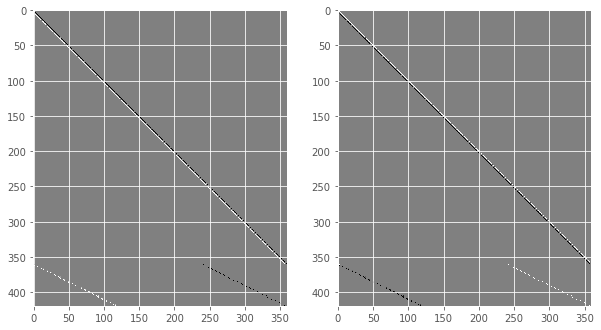

Frobenius norm between J_analytical and J_autodiff is: 59.190242767333984


In [41]:
def analytical_jacobian(poses, graph):
    n = np.prod(poses.shape)
    m = len(graph.anchors[0]) * 3 + len(graph.edges) * 3

    n_anchors = 3 * len(graph.anchors[0])
    J = np.zeros(shape=(m, n))

    J[:n_anchors, :n_anchors] = np.eye(n_anchors)    
    for i, edge in enumerate(graph.edges):
        u_index = 3 * edge.u
        v_index = 3 * edge.v
        constraint_index = n_anchors + 3 * i
        J[constraint_index:constraint_index+3, u_index:u_index+3] = np.array([
            [1, 0, - edge.d_x * np.sin(poses[edge.u, 2]) - edge.d_y * np.cos(poses[edge.u, 2])],
            [0, 1, - edge.d_y * np.sin(poses[edge.u, 2]) + edge.d_x * np.cos(poses[edge.u, 2])],
            [0, 0,                                                                           1],
        ])
        J[constraint_index:constraint_index+3, v_index:v_index+3] = np.array([
            [-1,  0,  0],
            [ 0, -1,  0],
            [ 0,  0, -1],
        ])    
    return J
      
J_analytical = analytical_jacobian(graph.node_matrix, graph)
J_autodiff = jax.jacfwd(residual, argnums=0)(graph.node_matrix, graph).reshape((420, -1))

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(J_analytical, cmap='gray')
plt.subplot(122)
plt.imshow(J_autodiff, cmap='gray')
plt.show()

def frobenius_norm(p1, p2):
    jnp.set_printoptions(suppress=True)
    val = np.linalg.norm(p1 - p2, 'fro')
    print(f"Frobenius norm between J_analytical and J_autodiff is: {val}")
    return val

assert frobenius_norm(J_analytical, J_autodiff) < 100

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

### The residuals computed

The shape of the residuals is `(number-of-anchors * 3 + number-of-edges * 3)`.

Since the edges are of two different types, this can also be written as `(number-of-anchors * 3 + number-of-odometry-edges * 3 + number-of-loop-closures * 3)`

This is a 1-rank object, all the 3-dimentionality of the transform is flattened into a simple vector of residuals, or errors.

We first compute the residuals due to any movement of the anchor points, we have only 1 anchor point in our implementation.

```python
# Add error of moving the anchors around to the residue
anchors_present = jnp.stack([nodes[idx] for idx in graph.anchors[0]], axis=0)
anchor_movement = np.squeeze(anchors_present - graph.anchor_matrix)
residue.extend(anchor_movement)
```

This gives us the round trip error for all the edges. We first go from u to v using a odometry based pose transform and we compare it against our current belief state that is being modified using both the initial odometry information and the loop closures informations.

```python
# Add residues for all other edges, direct measures and loop closures
for edge in graph.edges:
    u_pose = nodes[edge.u] # This is the actual u-pose
    v_pose = nodes[edge.v] # This is the actual v-pose
    # This transforms the u_pose based on the edge information to reach the odometry predicted v_pose

    # We first go to the frame of u, and take the x-y step in that theta rotated frame, and add it all
    u_pose += jnp.array([
        [jnp.cos(u_pose[2]), -jnp.sin(u_pose[2]), 0],
        [jnp.sin(u_pose[2]),  jnp.cos(u_pose[2]), 0],
        [                 0,                   0, 1],
    ]) @ jnp.array([edge.d_x, edge.d_y, edge.d_theta])

    # This is the residual
    round_trip_error = v_pose - u_pose
    residue.extend(round_trip_error)
```



This is what our residual matrix looks like, all the terms are errors in the given quantities, the residual is a single dimentional object, a vector:

\begin{bmatrix}
    \text{anchor $x$} \\
    \text{anchor $y$} \\
    \text{anchor $\theta$} \\
    \text{odometry edge 1 $x$} \\
    \text{odometry edge 1 $y$} \\
    \text{odometry edge 1 $\theta$} \\
    \text{odometry edge 2 $x$} \\
    \text{odometry edge 2 $y$} \\
    \text{odometry edge 2 $\theta$} \\
    \ldots\\
    \text{odometry edge $n_e$ $x$} \\
    \text{odometry edge $n_e$ $y$} \\
    \text{odometry edge $n_e$ $\theta$} \\
    \text{loop closure 1 $x$} \\
    \text{loop closure 1 $y$} \\
    \text{loop closure 1 $\theta$} \\
    \text{loop closure 2 $x$} \\
    \text{loop closure 2 $y$} \\
    \text{loop closure 2 $\theta$} \\
    \ldots\\
    \text{loop closure $n_l$ $x$} \\
    \text{loop closure $n_l$ $y$} \\
    \text{loop closure $n_l$ $\theta$} \\
\end{bmatrix}

### Jacobain Computation

The Jacobian is of the shape `Number of constraints` $\times$ `Number of variables`

If we have n-points, we have $3 \times n` variables. We have one constraint for each of the graph edges, both loop closures and the anchors. These edges are of exactly the same form as shown above in the residuals.

So each term of the matrix is of the form:
\begin{bmatrix}
    \frac{\partial \text{residual}_i}{\partial \text{coordinate_}}
\end{bmatrix}

### Experimental Observations

With odometry information being downweighted, the trajectories start aggrevating their loop closures and ignore the relative pose information almost completely, converging to very spiraling tracks. (Note: A linear shift doesn't matter since we only anchor the first point)
* Odometry info: 100
* Loop Closure: 1000
* Anchor Points: 2000
![image-1.png](../results/img/slam-optimization-1.png)

Adding more value to odometry, we see the situation improve. 
* Odometry info: 400
* Loop Closure: 1000
* Anchor Points: 2000

![image-2.png](../results/img/slam-optimization-2.png)

These are all almost oval trajectories, even if the net angle and mean position are shifted due to insufficient anchorage.

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

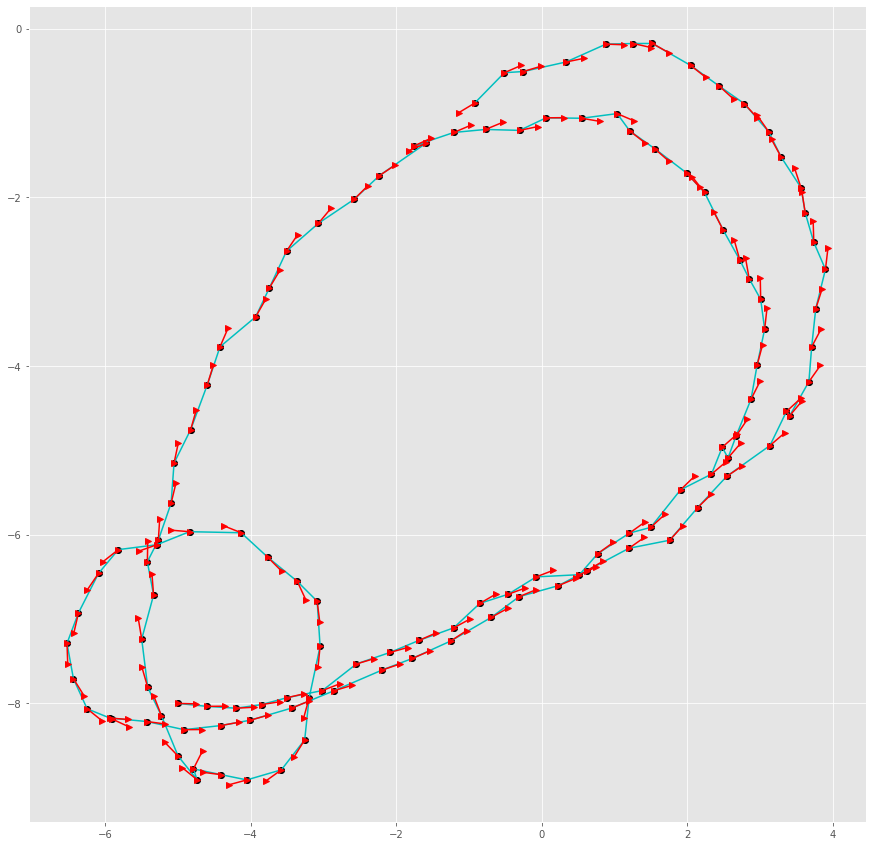

In [36]:
optimized_graph = copy.deepcopy(graph)
optimized_graph.color = 'r'
optimized_graph.load_node_matrix(final_poses)
optimized_graph.draw()
plt.show()

In [37]:
os.makedirs("../results/q2", exist_ok=True)
graph.write("../results/q2/optimized_trajectory.g2o")